Essaie de modèle et approche de prédiction

#Import

##Librairies

In [ ]:
pip install kmodes

In [ ]:
# import des librairies
import pandas as pd
import numpy as np

# Pour afficher les graphiques dans la continuité du code,
# et non pas dans une fenêtre à part:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as st
import matplotlib.cm as cm
import plotly.express as px
from math import pi

#Anova
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats as sms

#PCA
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection
from sklearn import metrics
from sklearn.preprocessing import normalize

#Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split

#Clustering
from sklearn.cluster import DBSCAN, KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from kmodes.kmodes import KModes
import plotly.graph_objects as go
import scipy.cluster.hierarchy as shc

#Date
import datetime as dt

In [ ]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

<ipython-input-3-358864a12876>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


##Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OC Projet5/dataEcom_Exploration.csv', sep = ',')

# Modélisation

##Etude bref et rapide du dataset

In [ ]:
data.shape

(99441, 5)

In [ ]:
data.head()

,customer_unique_id,customer_id,order_purchase_timestamp,payment_value,review_score
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,146.87,4.0
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:48:24,335.48,5.0
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-19 16:07:45,157.73,5.0
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 16:06:38,173.30,5.0
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 09:51:30,252.25,5.0


In [ ]:
data.tail()

,customer_unique_id,customer_id,order_purchase_timestamp,payment_value,review_score
99436,1a29b476fee25c95fbafc67c5ac95cf8,17ddf5dd5d51696bb3d7c6291687be6f,2018-04-07 15:48:17,88.78,4.0
99437,d52a67c98be1cf6a5c84435bd38d095d,e7b71a9017aa05c9a7fd292d714858e8,2018-04-04 08:20:22,129.06,5.0
99438,e9f50caf99f032f0bf3c55141f019d99,5e28dfe12db7fb50a4b2f691faecea5e,2018-04-08 20:11:50,56.04,1.0
99439,73c2643a0a458b49f58cea58833b192e,56b18e2166679b8a959d72dd06da27f9,2017-11-03 21:08:33,711.07,5.0
99440,84732c5050c01db9b23e19ba39899398,274fa6071e5e17fe303b9748641082c8,2017-12-19 14:27:23,21.77,5.0


In [ ]:
data.dtypes

customer_unique_id          object 
customer_id                 object 
order_purchase_timestamp    object 
payment_value               float64
review_score                float64
dtype: object

In [ ]:
data.isna().sum()

customer_unique_id          0
customer_id                 0
order_purchase_timestamp    0
payment_value               0
review_score                0
dtype: int64

##Méthode RFM

Pour réaliser notre segmentation on se basera sur la méthode RFM.

La segmentation RFM prend en compte la **Récence** (date de la dernière commande), la **Fréquence** des commandes et le **Montant** ( de la derniere commande ou sur une période donnée) pour établir des segments de clients homogènes.

In [ ]:
# Recherche de la plus anciennes date d'achat
ancien = data["order_purchase_timestamp"].min()
ancien

'2016-09-04 21:15:19'

In [ ]:
# Recherche de la plus recente date
recent = data["order_purchase_timestamp"].max()
recent

'2018-10-17 17:30:18'

In [ ]:
#On change le format d'affichage de la date
aammjj = str.split(str.split(recent)[0], "-")
NOW = dt.datetime(int(aammjj[0]), int(aammjj[1]), int(aammjj[2]))

In [ ]:
aammjj

['2018', '10', '17']

In [ ]:
NOW

datetime.datetime(2018, 10, 17, 0, 0)

In [ ]:
# Change the type of "order_purchase_timestamp" at datetime
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])

In [ ]:
data.dtypes

customer_unique_id          object        
customer_id                 object        
order_purchase_timestamp    datetime64[ns]
payment_value               float64       
review_score                float64       
dtype: object

### Simulation RFM (RFM )

In [ ]:
# Table RFM
#
# Recency: Nombre de jours depuis le dernier achat
#
# Frequency: Nombre de fois que le client a acheter
#
# Monetary: Dépenses total du client
rfmTable = data.groupby('customer_unique_id').\
            agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                 "customer_id": lambda x: len(x.unique()),
                 "payment_value": lambda x: sum(x)})

rfmTable['order_purchase_timestamp'] = rfmTable['order_purchase_timestamp'].astype(int)
rfmTable.rename(columns={'order_purchase_timestamp': 'recency',
                         'customer_id': 'frequency',
                         'payment_value': 'monetary_value'}, inplace=True)
rfmTable.head()

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19
0000f46a3911fa3c0805444483337064,585,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62
0004aac84e0df4da2b147fca70cf8255,336,1,196.89


In [ ]:
rfmTable.describe()

,recency,frequency,monetary_value
count,96096.000000,96096.000000,96096.000000
mean,287.108808,1.034809,163.846247
std,153.417865,0.214384,228.965034
min,-1.000000,1.000000,0.000000
25%,163.000000,1.000000,61.520000
50%,268.000000,1.000000,106.310000
75%,396.000000,1.000000,180.992500
max,772.000000,17.000000,13664.080000


In [ ]:
segmented_rfm = rfmTable.copy() #Copie du tableau

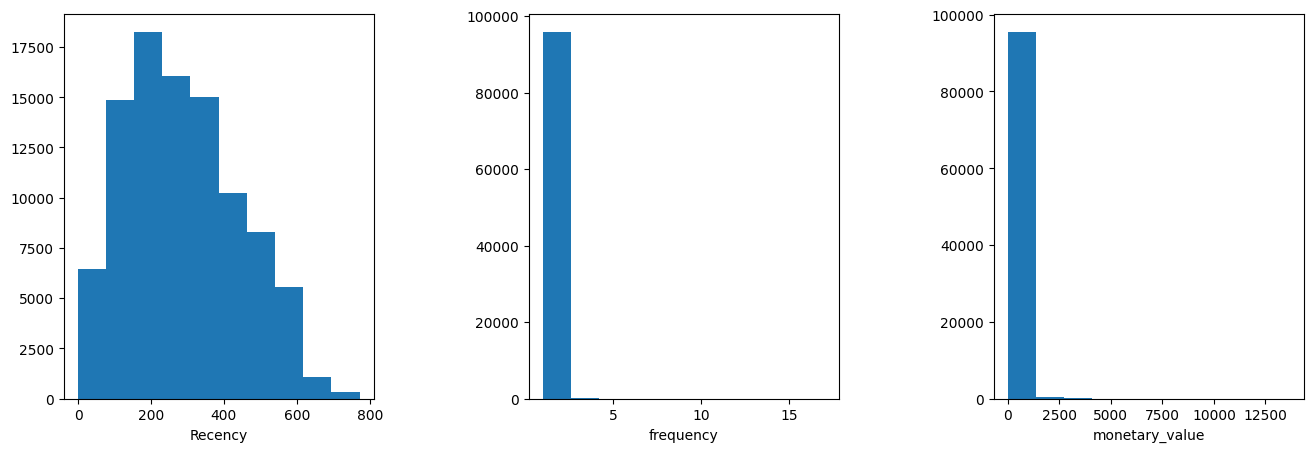

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace= 0.5)

plt.subplot(131)
plt.hist(segmented_rfm["recency"])
plt.xlabel('Recency')

plt.subplot(132)
fig = plt.hist(segmented_rfm["frequency"])
plt.xlabel('frequency')

plt.subplot(133)
fig = plt.hist(segmented_rfm["monetary_value"])
plt.xlabel('monetary_value')

plt.show()

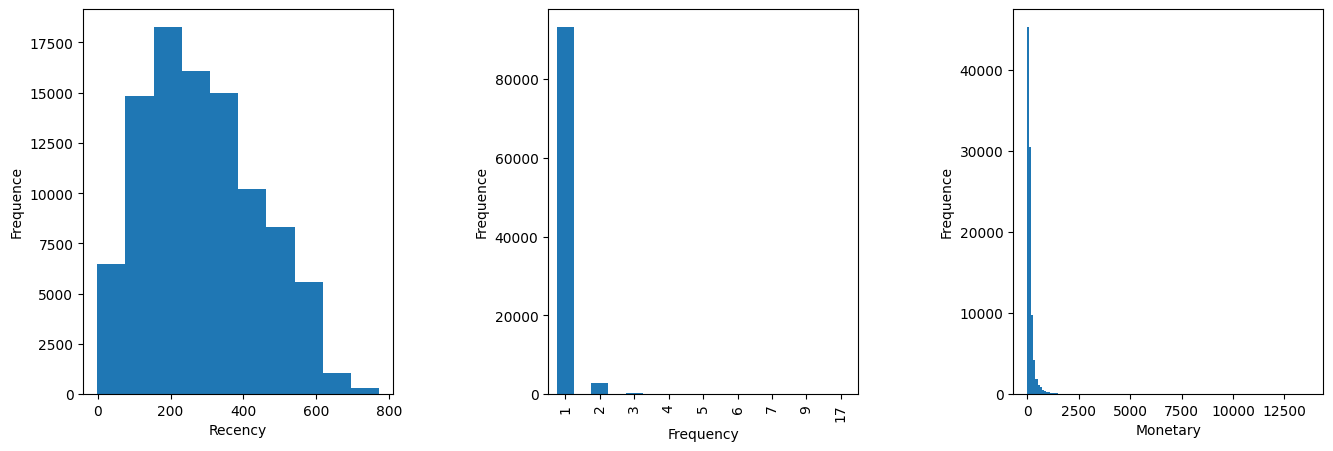

In [ ]:
def compute_histogram_bins(data, desired_bin_size):
    min_val = np.min(data)
    max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    return bins

r = segmented_rfm['recency']
m = segmented_rfm['monetary_value']

plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace= 0.5)

# Recency
plt.subplot(131)
plt.xlabel('Recency')
plt.ylabel('Frequence')
counts, bins = np.histogram(r)
plt.hist(bins[:-1], bins, weights=counts)

# Frequency
plt.subplot(132)
plt.xlabel('Frequency')
plt.ylabel('Frequence')
segmented_rfm['frequency'].value_counts().plot(kind="bar", width=0.5)

# Monetary
plt.subplot(133)
plt.xlabel('Monetary')
plt.ylabel('Frequence')
bins = compute_histogram_bins(m, 100)
plt.hist(m, bins=bins)

plt.show()

On peut voir à travers les histogram comment sont distribué les clients sur les différentes variable de notre analyse.

On remarque ainsi que
 - beaucoup de clients achète en moins de 300 jours
 - La fréquence d'achat est globale de 1 (les clients achète juste une fois dans la période étudier)
 - les dépenses ne sont pas très très variable

{'whiskers': [<matplotlib.lines.Line2D at 0x78730e3bfca0>,
 'caps': [<matplotlib.lines.Line2D at 0x78730e1ec220>,
 'boxes': [<matplotlib.lines.Line2D at 0x78730e3bead0>],
 'medians': [<matplotlib.lines.Line2D at 0x78730e1ec760>],
 'fliers': [<matplotlib.lines.Line2D at 0x78730e1eca00>],
 'means': []}

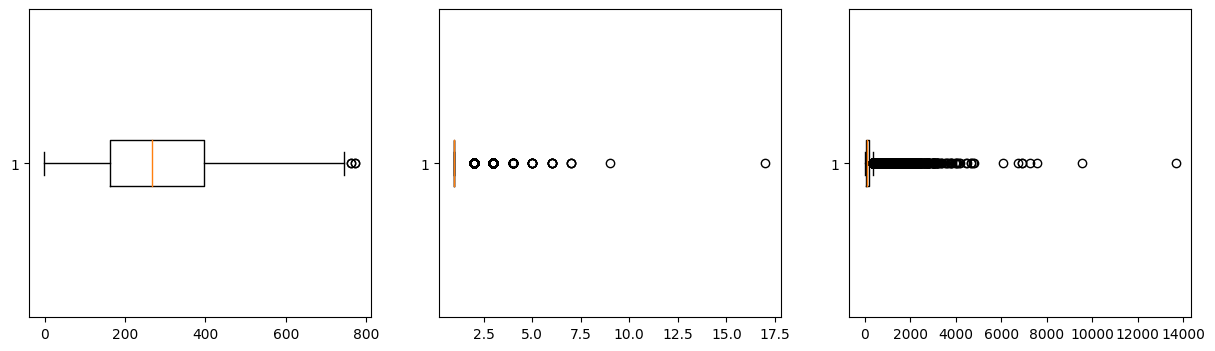

In [ ]:
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(131)
ax.boxplot(segmented_rfm["recency"], vert=False)

ax = fig.add_subplot(132)
ax.boxplot(segmented_rfm["frequency"], vert=False)

ax = fig.add_subplot(133)
ax.boxplot(segmented_rfm["monetary_value"], vert=False)

In [ ]:
segmented_rfm

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19
0000f46a3911fa3c0805444483337064,585,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62
0004aac84e0df4da2b147fca70cf8255,336,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,495,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,310,1,84.58
ffff371b4d645b6ecea244b27531430a,616,1,112.46


In [ ]:
segmented_rfm['R_rank'] = segmented_rfm['recency'].rank(ascending=False)
segmented_rfm['F_rank'] = segmented_rfm['frequency'].rank(ascending=True)
segmented_rfm['M_rank'] = segmented_rfm['monetary_value'].rank(ascending=True)

# normalizing the rank of the customers
segmented_rfm['R_rank_norm'] = (segmented_rfm['R_rank']/segmented_rfm['R_rank'].max())*100
segmented_rfm['F_rank_norm'] = (segmented_rfm['F_rank']/segmented_rfm['F_rank'].max())*100
segmented_rfm['M_rank_norm'] = (segmented_rfm['F_rank']/segmented_rfm['M_rank'].max())*100

segmented_rfm.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

segmented_rfm.head()


,recency,frequency,monetary_value,R_rank_norm,F_rank_norm,M_rank_norm
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90,76.264361,48.441142,48.441142
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19,75.239864,48.441142,48.441142
0000f46a3911fa3c0805444483337064,585,1,86.22,3.661963,48.441142,48.441142
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,28.923160,48.441142,48.441142
0004aac84e0df4da2b147fca70cf8255,336,1,196.89,33.970196,48.441142,48.441142


Le score RFM est calculé en fonction de la récence, de la fréquence et de la valeur monétaire normalisant les classements. Sur la base de ce score, nous divisons nos clients. Ici, nous les évaluons sur une échelle de 5. La formule utilisée pour calculer le score rfm est :

0,15*Score de récence + 0,28*Score de fréquence + 0,57 *Score monétaire

La récence à 15% de valeur dans notre scoring

La fréquence à 28% de valeur dans notre scoring

Le montant dépensé à 57% de valeur dans notre scoring

In [ ]:
#Calcul du score rfm
segmented_rfm['RFM_Score'] = 0.15*segmented_rfm['R_rank_norm'] + 0.28*segmented_rfm['F_rank_norm'] + 0.57*segmented_rfm['M_rank_norm']
segmented_rfm['RFM_Score'] *= 0.05
segmented_rfm = segmented_rfm.round(2)
segmented_rfm[['RFM_Score']].head(10)

,RFM_Score
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,2.63
0000b849f77a49e4a4ce2b2a4ca5be3f,2.62
0000f46a3911fa3c0805444483337064,2.09
0000f6ccb0745a6a4b88665a16c9f078,2.28
0004aac84e0df4da2b147fca70cf8255,2.31
0004bd2a26a76fe21f786e4fbd80607f,2.57
00050ab1314c0e55a6ca13cf7181fecf,2.59
00053a61a98854899e70ed204dd4bafe,2.50
0005e1862207bf6ccc02e4228effd9a0,2.08


Rating Customer based upon the RFM score

rfm score >4.5 : Top Customer

4.5 > rfm score > 4 : High Value Customer

4>rfm score >3 : Medium value customer

3>rfm score>1.6 : Low-value customer

rfm score< 1.6 :Lost Customer


In [ ]:
segmented_rfm["Customer_segment"] = np.where(segmented_rfm['RFM_Score'] >
									4.5, "Top Customers",
									(np.where(
										segmented_rfm['RFM_Score'] > 4,
										"High value Customer",
										(np.where(
	segmented_rfm['RFM_Score'] > 3,
							"Medium Value Customer",
							np.where(segmented_rfm['RFM_Score'] > 1.6,
							'Low Value Customers', 'Lost Customers'))))))
segmented_rfm[['RFM_Score', 'Customer_segment']].head(20)

,RFM_Score,Customer_segment
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,2.63,Low Value Customers
0000b849f77a49e4a4ce2b2a4ca5be3f,2.62,Low Value Customers
0000f46a3911fa3c0805444483337064,2.09,Low Value Customers
0000f6ccb0745a6a4b88665a16c9f078,2.28,Low Value Customers
0004aac84e0df4da2b147fca70cf8255,2.31,Low Value Customers
0004bd2a26a76fe21f786e4fbd80607f,2.57,Low Value Customers
00050ab1314c0e55a6ca13cf7181fecf,2.59,Low Value Customers
00053a61a98854899e70ed204dd4bafe,2.50,Low Value Customers
0005e1862207bf6ccc02e4228effd9a0,2.08,Low Value Customers


In [ ]:
segmented_rfm[['RFM_Score', 'Customer_segment']].sort_values(by ='RFM_Score',  ascending= False ).head(20)

,RFM_Score,Customer_segment
customer_unique_id,,
dc813062e0fc23409cd255f7f53c7074,5.00,Top Customers
34b0cd95480e55c2a701293a2b9671b3,4.99,Top Customers
8d50f5eadf50201ccdcedfb9e2ac8455,4.99,Top Customers
e0836a97eaae86ac4adc26fbb334a527,4.99,Top Customers
ba84da8c159659f116329563a0a981dd,4.99,Top Customers
9cc5a07f169a1606fd347a56683e6ea6,4.99,Top Customers
af5454198a97379394cacf676e1e96cb,4.99,Top Customers
ff36be26206fffe1eb37afd54c70e18b,4.99,Top Customers
230a1e9f42924d41f37fd22a1d4a9707,4.99,Top Customers


Nous allons visualiser les seegment de clients dans notre dataset

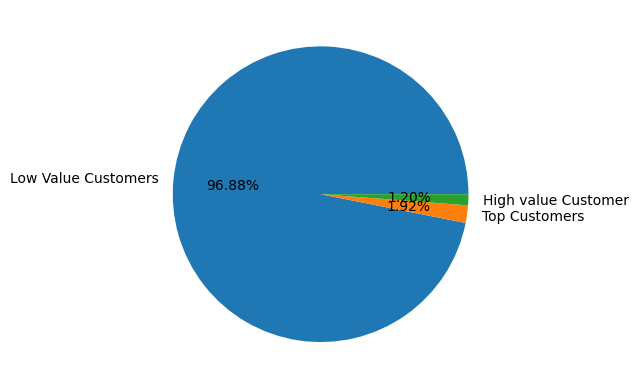

In [ ]:
plt.pie(segmented_rfm.Customer_segment.value_counts(),
		labels=segmented_rfm.Customer_segment.value_counts().index,
		autopct='%.2f%%')
plt.show()

In [ ]:
segmented_rfm_table = segmented_rfm.Customer_segment.value_counts()
segmented_rfm_table.shape

(3,)

Text(0, 0.5, 'Nombre de clients par segments')

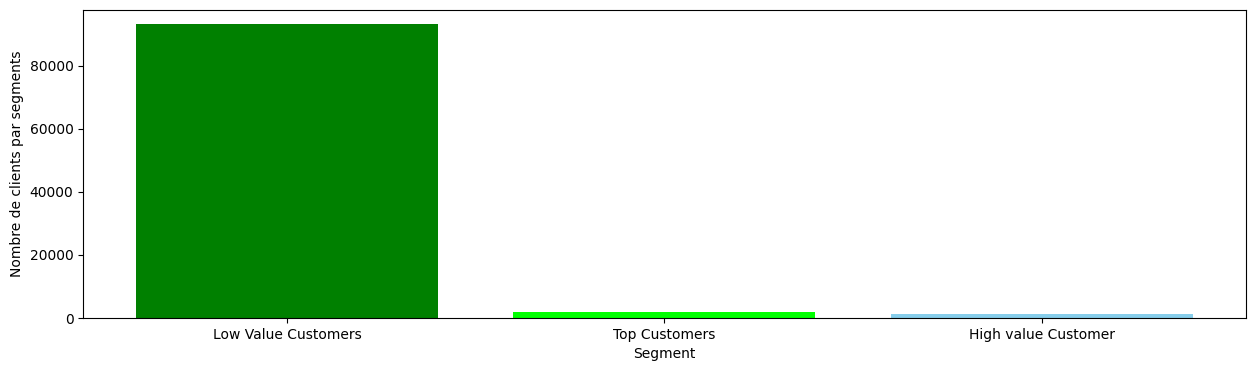

In [ ]:
#Bar chat pour le nombre de clients par segments
plt.figure(figsize=(15, 4))
plt.bar(segmented_rfm_table.index, segmented_rfm_table, align='center',
        color=["green", "lime", "#87ceeb", "yellow", "orange"]
       )
plt.xlabel('Segment')
plt.ylabel('Nombre de clients par segments')

In [ ]:
# # Fonction radar_plot
# def radar_plot(rfm_table,
#                label_score,
#                colors,
#                sub_plot=[3, 3],
#                figsize=(36, 18)):

#     """
#     Pour chaque cluster/segments, trace un radar chart représentant
#     la moyenne des individus pour les variables Recency, Monetary
#     et Frequency, ainsi que le nombre d'individus dans le cluster/segment
#     en question.
#     rfmTable(pd.DataFrame): Table de résultats, doit contenir
#     les 3 variables Recency, Frequency et Monetary
#     ainsi que la colonne avec les segments de chaque individu
#     label_score: nom de la segmentation
#     colors(list): code couleur
#     """

#     # Aggrégation par moyenne des valeurs par segment
#     df_plot = rfm_table.groupby([label_score]).agg("mean")

#     # Transformation MinMax -> [0, 1]
#     df_plot_std = pd.DataFrame(MinMaxScaler().fit_transform(df_plot),
#                            columns=list(df_plot.columns),
#                            index=df_plot.index)

#     # Noms des variables
#     categories = list(df_plot.columns)
#     # Nombre de variables
#     N = len(categories)

#     # Quel sera l'angle de chaque axe ?
#     # On divise un tour complet par le nombre de variables
#     angles = [n / float(N) * 2 * pi for n in range(N)]
#     angles += angles[:1]

#     fig = plt.figure(1, figsize=figsize)

#     # Trace un radar chart pour chaque segment
#     for i, segment in enumerate(rfm_table[label_score].unique()):

#         ax = fig.add_subplot(sub_plot[0], sub_plot[1], i + 1, polar=True)

#         ax.set_theta_offset(pi / 2)
#         ax.set_theta_direction(-1)
#         ax.set_rlabel_position(0)

#         # Draw one axe per variable + add labels labels yet
#         plt.yticks(color="grey", size=2)
#         values = list(df_plot_std.loc[segment].values)
#         values += values[:1]
#         ax.plot(angles, values, colors[segment],
#                 'o-', linewidth=2, linestyle='solid')
#         ax.fill(angles, values, colors[segment], alpha=0.25)
#         ax.set_xticks(angles)
#         ax.set_xticklabels(categories, size=15)
#         plt.yticks([-1, -0.5, 0, 0.5, 1],
#                    ["-1", "-0.5", "0", "0.5", "1"],
#                    color="black",
#                    size=12)
#         ax.set_title(segment, size=15, color=colors[segment])
#         ax.grid(True)
#         plt.ylim(-1, 1)

#     plt.show()

In [ ]:
# # Radar plot
# # Liste des couleurs pour chaque segment
# palette_1 = sns.color_palette("husl", 5)
# colors_1 = {label: color for label, color in zip(5,palette_1.as_hex())}

In [ ]:
# # Radar plot pour la segmentation
# radar_plot(segmented_rfm.drop(columns=['R_rank_norm','F_rank_norm','M_rank_norm']),'RFM_Score',
#            {'green', 'blue', 'purple', 'yellow', 'red'},
#            sub_plot=[3, 3],
#            figsize=(45, 28))

###Simulation avec review score (RFMS)

In [ ]:
# Table RFMS
#
# Recency: Nombre de jours depuis le dernier achat
#
# Frequency: Nombre de fois que le client a acheter
#
# Monetary: Dépenses total du client
#
#Score: Moyenne des scores noté par le client
rfmsTable = data.groupby('customer_unique_id').\
            agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                 "customer_id": lambda x: len(x.unique()),
                 "payment_value": lambda x: sum(x),
                "review_score": lambda x: sum(x)})

rfmsTable['order_purchase_timestamp'] = rfmsTable['order_purchase_timestamp'].astype(int)
rfmsTable.rename(columns={'order_purchase_timestamp': 'recency',
                         'customer_id': 'frequency',
                         'payment_value': 'monetary_value',
                        'review_score': 'score_review'}, inplace=True)
rfmsTable.head()

,recency,frequency,monetary_value,score_review
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19,4.0
0000f46a3911fa3c0805444483337064,585,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,336,1,196.89,5.0


In [ ]:
rfmsTable['score_review'].unique()

array([ 5.,  4.,  3.,  1.,  2.,  8.,  0., 10.,  6.,  7.,  9., 13., 14.,
       15., 20., 16., 30., 35., 12., 11., 19., 25., 29., 21., 27., 81.,
       17., 18.])

In [ ]:
segmented_rfms = rfmsTable.copy()

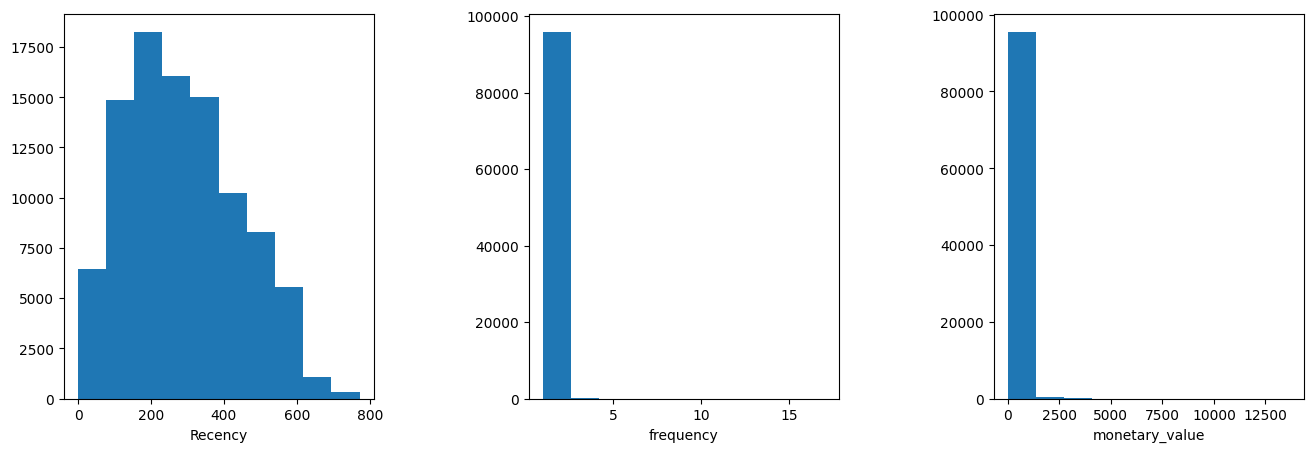

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace= 0.5)

plt.subplot(131)
plt.hist(segmented_rfms["recency"])
plt.xlabel('Recency')

plt.subplot(132)
fig = plt.hist(segmented_rfms["frequency"])
plt.xlabel('frequency')

plt.subplot(133)
fig = plt.hist(segmented_rfms["monetary_value"])
plt.xlabel('monetary_value')

plt.show()

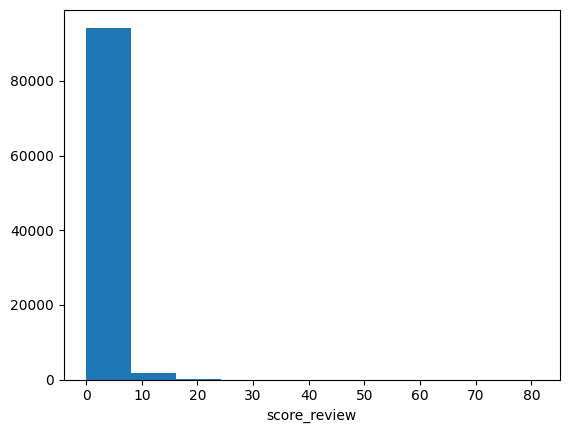

In [ ]:
fig = plt.hist(segmented_rfms["score_review"])
plt.xlabel('score_review')
plt.show()

In [ ]:
segmented_rfms['R_rank'] = segmented_rfms['recency'].rank(ascending=False)
segmented_rfms['F_rank'] = segmented_rfms['frequency'].rank(ascending=True)
segmented_rfms['M_rank'] = segmented_rfms['monetary_value'].rank(ascending=True)
segmented_rfms['S_rank'] = segmented_rfms['score_review'].rank(ascending=True)

# normalizing the rank of the customers
segmented_rfms['R_rank_norm'] = (segmented_rfms['R_rank']/segmented_rfms['R_rank'].max())*100
segmented_rfms['F_rank_norm'] = (segmented_rfms['F_rank']/segmented_rfms['F_rank'].max())*100
segmented_rfms['M_rank_norm'] = (segmented_rfms['F_rank']/segmented_rfms['M_rank'].max())*100
segmented_rfms['S_rank_norm'] = (segmented_rfms['S_rank']/segmented_rfms['S_rank'].max())*100

segmented_rfms.drop(columns=['R_rank', 'F_rank', 'M_rank', 'S_rank'], inplace=True)

segmented_rfms.head()


,recency,frequency,monetary_value,score_review,R_rank_norm,F_rank_norm,M_rank_norm,S_rank_norm
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90,5.0,76.264361,48.441142,48.441142,69.541916
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19,4.0,75.239864,48.441142,48.441142,32.407176
0000f46a3911fa3c0805444483337064,585,1,86.22,3.0,3.661963,48.441142,48.441142,19.037733
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,4.0,28.923160,48.441142,48.441142,32.407176
0004aac84e0df4da2b147fca70cf8255,336,1,196.89,5.0,33.970196,48.441142,48.441142,69.541916


Le score RFMS est calculé en fonction de la récence, de la fréquence et de la valeur monétaire normalisant les classements. Sur la base de ce score, nous divisons nos clients. Ici, nous les évaluons sur une échelle de 5. La formule utilisée pour calculer le score rfm est :

0,15*Score de récence + 0,25*Score de fréquence + 0,50 *Score monétaire + 0,10 * Score noté par le client

In [ ]:
#Calcul du score rfms
segmented_rfms['RFMS_Score'] = 0.15*segmented_rfms['R_rank_norm'] + 0.25*segmented_rfms['F_rank_norm'] + 0.50*segmented_rfms['M_rank_norm'] + 0.10*segmented_rfms['S_rank_norm']
segmented_rfms['RFMS_Score'] *= 0.05
segmented_rfms = segmented_rfms.round(2)
segmented_rfms[['RFMS_Score']].head(10)

,RFMS_Score
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,2.74
0000b849f77a49e4a4ce2b2a4ca5be3f,2.54
0000f46a3911fa3c0805444483337064,1.94
0000f6ccb0745a6a4b88665a16c9f078,2.20
0004aac84e0df4da2b147fca70cf8255,2.42
0004bd2a26a76fe21f786e4fbd80607f,2.49
00050ab1314c0e55a6ca13cf7181fecf,2.51
00053a61a98854899e70ed204dd4bafe,2.29
0005e1862207bf6ccc02e4228effd9a0,2.00


Rating Customer based upon the RFMS score

rfms score >4.5 : Top Customer

4.5 > rfms score > 4 : High Value Customer

4>rfms score >3 : Medium value customer

3>rfms score>1.6 : Low-value customer

rfms score< 1.6 :Lost Customer


In [ ]:
segmented_rfms["Customer_segment"] = np.where(segmented_rfms['RFMS_Score'] >
									4.5, "Top Customers",
									(np.where(
										segmented_rfms['RFMS_Score'] > 4,
										"High value Customer",
										(np.where(
	segmented_rfms['RFMS_Score'] > 3,
							"Medium Value Customer",
							np.where(segmented_rfms['RFMS_Score'] > 1.6,
							'Low Value Customers', 'Lost Customers'))))))
segmented_rfms[['RFMS_Score', 'Customer_segment']].head(20)

,RFMS_Score,Customer_segment
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,2.74,Low Value Customers
0000b849f77a49e4a4ce2b2a4ca5be3f,2.54,Low Value Customers
0000f46a3911fa3c0805444483337064,1.94,Low Value Customers
0000f6ccb0745a6a4b88665a16c9f078,2.20,Low Value Customers
0004aac84e0df4da2b147fca70cf8255,2.42,Low Value Customers
0004bd2a26a76fe21f786e4fbd80607f,2.49,Low Value Customers
00050ab1314c0e55a6ca13cf7181fecf,2.51,Low Value Customers
00053a61a98854899e70ed204dd4bafe,2.29,Low Value Customers
0005e1862207bf6ccc02e4228effd9a0,2.00,Low Value Customers


In [ ]:
segmented_rfms[['RFMS_Score', 'Customer_segment']].sort_values(by ='RFMS_Score',  ascending= False ).head(20)

,RFMS_Score,Customer_segment
customer_unique_id,,
dc813062e0fc23409cd255f7f53c7074,5.00,Top Customers
230a1e9f42924d41f37fd22a1d4a9707,4.99,Top Customers
e53fd5575f1418397aae732c5755b6fc,4.99,Top Customers
e0836a97eaae86ac4adc26fbb334a527,4.99,Top Customers
f8bc1d81f395f6239a2a5ab1b9edf1ab,4.99,Top Customers
8d50f5eadf50201ccdcedfb9e2ac8455,4.99,Top Customers
34b0cd95480e55c2a701293a2b9671b3,4.99,Top Customers
9cc5a07f169a1606fd347a56683e6ea6,4.99,Top Customers
394ac4de8f3acb14253c177f0e15bc58,4.98,Top Customers


Nous allons visualiser les seegment de clients dans notre dataset

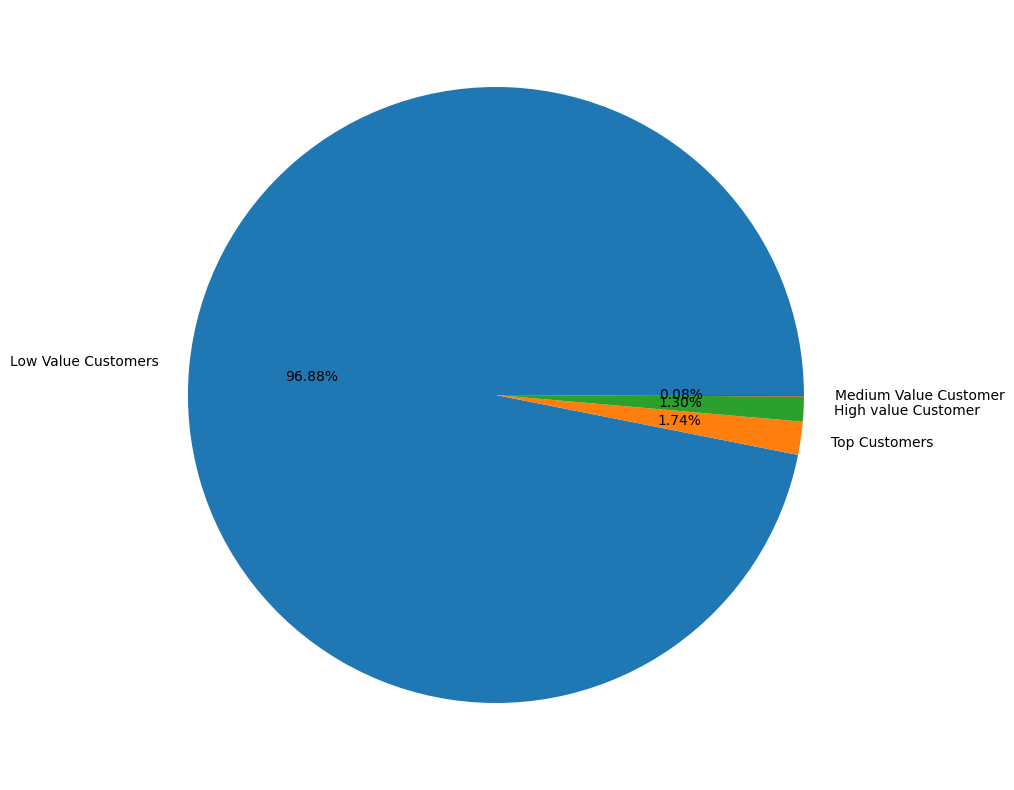

In [ ]:
plt.figure(figsize = (10,10))
plt.pie(segmented_rfms.Customer_segment.value_counts(),
		labels=segmented_rfms.Customer_segment.value_counts().index,
		autopct='%.2f%%')
plt.show()

In [ ]:
segmented_rfms_table = segmented_rfms.Customer_segment.value_counts()
segmented_rfms_table.shape

(4,)

Text(0, 0.5, 'Nombre de clients par segments')

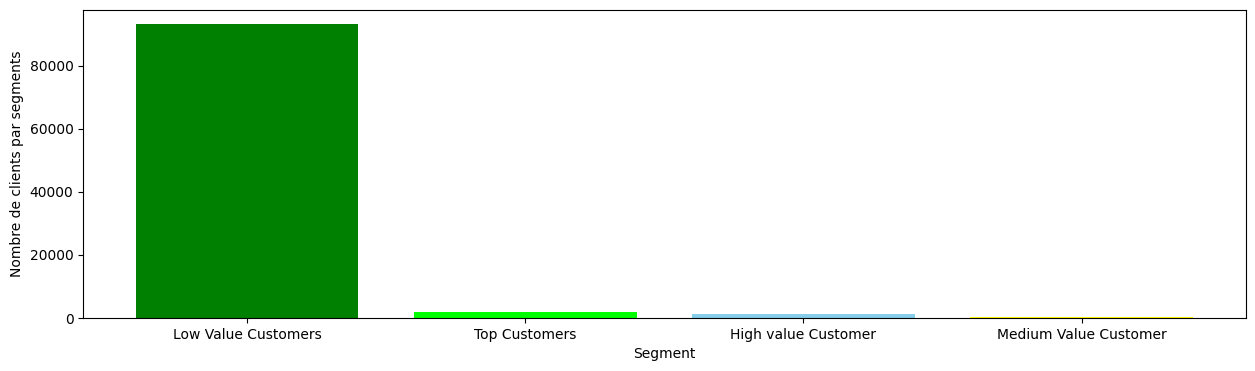

In [ ]:
#Bar chat pour le nombre de clients par segments
plt.figure(figsize=(15, 4))
plt.bar(segmented_rfms_table.index, segmented_rfms_table, align='center',
        color=["green", "lime", "#87ceeb", "yellow", "orange"]
       )
plt.xlabel('Segment')
plt.ylabel('Nombre de clients par segments')


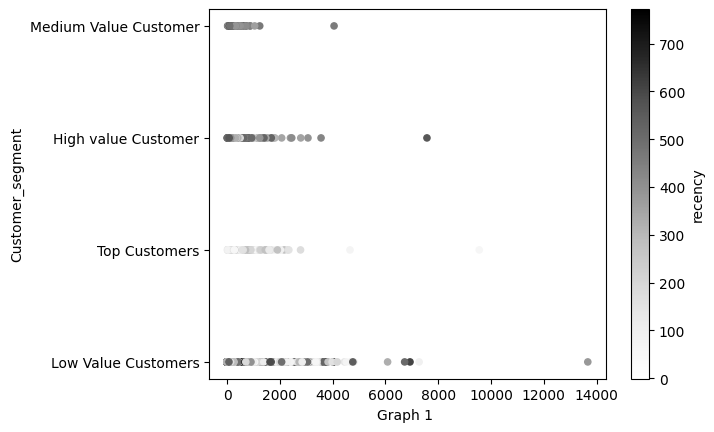

In [ ]:
fig = segmented_rfms.plot.scatter(x = 'monetary_value', c= 'recency', y = 'Customer_segment' )
plt.xlabel('Graph 1 ')

plt.show()

Text(0.5, 0, 'Graph2')

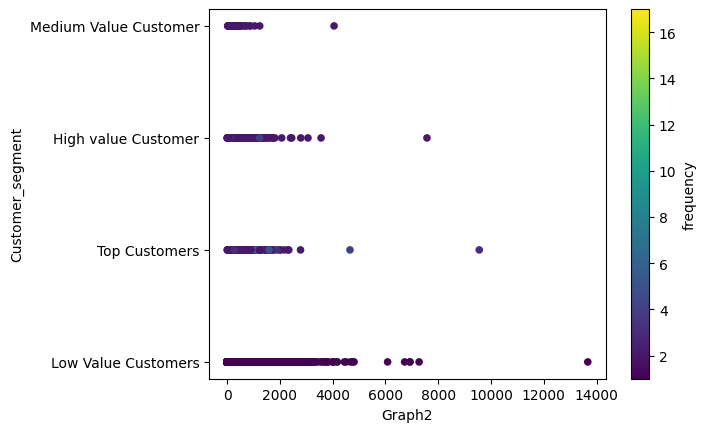

In [ ]:
fig = segmented_rfms.plot.scatter(x = 'monetary_value', c= 'frequency', y = 'Customer_segment', colormap='viridis' )
plt.xlabel('Graph2')

Text(0.5, 0, 'Graph3')

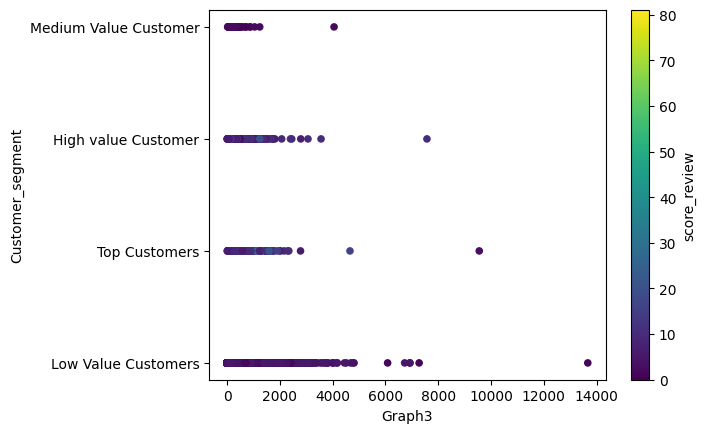

In [ ]:
fig = segmented_rfms.plot.scatter(x = 'monetary_value', c= 'score_review', y = 'Customer_segment' )
plt.xlabel('Graph3')

## Methode de clustering k-means

### KMEANS RFM

Simulation k-means avec un nombre « k » de clusters entre 2 et 15

In [ ]:
segmented_rfm_clust = rfmTable.copy()
segmented_rfm_clust

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19
0000f46a3911fa3c0805444483337064,585,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62
0004aac84e0df4da2b147fca70cf8255,336,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,495,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,310,1,84.58
ffff371b4d645b6ecea244b27531430a,616,1,112.46


In [ ]:
#Standardiser les données
Scal = StandardScaler()
std_segmented_rfm_clust = Scal.fit_transform(segmented_rfm_clust.astype(float))
std_segmented_rfm_clust

array([[-0.83503622, -0.16236828, -0.09585028],
       [-0.81548168, -0.16236828, -0.59684641],
       [ 1.9417083 , -0.16236828, -0.33903278],
       ...,
       [ 2.14377187, -0.16236828, -0.22442953],
       [-0.78289079, -0.16236828, -0.13170747],
       [ 1.59624478, -0.16236828, -0.40306035]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

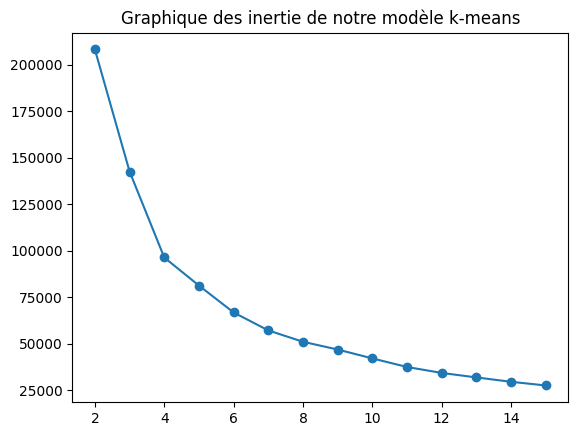

In [ ]:
#Appliquer le k-means
cluster_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

inertie = []

for c in cluster_range:
  kmeans = KMeans(init = 'k-means++', n_clusters = c).fit(std_segmented_rfm_clust)
  inertie.append(kmeans.inertia_)

#Afficher l'inertie

plt.Figure()
plt.plot(cluster_range,inertie, marker ='o')
plt.title("Graphique des inerties de notre modèle k-means")
plt.show()

Avec le graphe montrant les inertie, avec la méthode du coude on partira sur 4 clusters

In [ ]:
#ON utilisera 4 clusters

kmeans = KMeans(n_clusters= 4).fit(std_segmented_rfm_clust)
labels = kmeans.labels_
new_segmented_rfm_clust = pd.DataFrame(data = std_segmented_rfm_clust, columns =['recency', 'frequency', 'monetary_value'])
new_segmented_rfm_clust['labels_kmeans'] = labels
new_segmented_rfm_clust

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,recency,frequency,monetary_value,labels_kmeans
0,-0.835036,-0.162368,-0.095850,1
1,-0.815482,-0.162368,-0.596846,1
2,1.941708,-0.162368,-0.339033,0
3,0.533782,-0.162368,-0.525088,0
4,0.318682,-0.162368,0.144319,0
...,...,...,...,...
96091,1.355072,-0.162368,8.313862,3
96092,0.149209,-0.162368,-0.346195,0
96093,2.143772,-0.162368,-0.224430,0
96094,-0.782891,-0.162368,-0.131707,1


In [ ]:
new_segmented_rfm_clust.describe()

,recency,frequency,monetary_value,labels_kmeans
count,9.609600e+04,9.609600e+04,9.609600e+04,96096.000000
mean,1.475861e-16,-4.356599e-16,7.808162e-17,0.681100
std,1.000005e+00,1.000005e+00,1.000005e+00,0.657055
min,-1.877945e+00,-1.623683e-01,-7.155988e-01,0.000000
25%,-8.089635e-01,-1.623683e-01,-4.469101e-01,0.000000
50%,-1.245546e-01,-1.623683e-01,-2.512897e-01,1.000000
75%,7.097724e-01,-1.623683e-01,7.488629e-02,1.000000
max,3.160608e+00,7.447054e+01,5.896230e+01,3.000000


In [ ]:
new_segmented_rfm_clust['labels_kmeans'].unique()

array([1, 0, 2, 3], dtype=int32)

In [ ]:
cluster0 = new_segmented_rfm_clust[['recency', 'frequency', 'monetary_value']][new_segmented_rfm_clust['labels_kmeans']==0]
cluster1 = new_segmented_rfm_clust[['recency', 'frequency', 'monetary_value']][new_segmented_rfm_clust['labels_kmeans']==1]
cluster2 = new_segmented_rfm_clust[['recency', 'frequency', 'monetary_value']][new_segmented_rfm_clust['labels_kmeans']==2]
cluster3 = new_segmented_rfm_clust[['recency', 'frequency', 'monetary_value']][new_segmented_rfm_clust['labels_kmeans']==3]

In [ ]:
#Visualiser
#Radar plot
# labels_kmeans = 0
c0 = cluster0.describe()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=c0.loc['min'],
      theta=c0.columns,
      fill='toself',
      name='Minimun'
))
fig.add_trace(go.Scatterpolar(
      r=c0.loc['50%'],
      theta=c0.columns,
      fill='toself',
      name='Medium',
))
# fig.add_trace(go.Scatterpolar(
#       r=c0.loc['max'],
#       theta=c0.columns,
#       fill='toself',
#       name='Maximun'
# ))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 3],
    )),
  width = 500, height = 500,
  showlegend=True
)
fig.show()

Au regard des statistique de ce cluster, on comprends  que le premier cluster (Cluster0 du kmeans) comprends les clients qui on acheté récemment et qui ont dépensés peu d'argent et n'est pas fréquent

**Cluster I: Client ayant acheté un peu récemment et qui ont dépensés peu d'argent et qui est peu fréquent**

In [ ]:
#Visualiser
#Radar plot
# labels_kmeans = 1
c1 = cluster1.describe()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=c1.loc['min'],
      theta=c1.columns,
      fill='toself',
      name='Minimun'
))
fig.add_trace(go.Scatterpolar(
      r=c1.loc['50%'],
      theta=c1.columns,
      fill='toself',
      name='Medium'
))
# fig.add_trace(go.Scatterpolar(
#       r=c1.loc['max'],
#       theta=c1.columns,
#       fill='toself',
#       name='Maximun'
# ))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 4]
    )),
  width = 500, height = 500,
  showlegend=True
)
fig.show()

CLUSTER II : CLient ayant acheter pas très récemment et avec une fréquence d'achat modérés et ayant dépensées un peu d'argent

In [ ]:
#Visualiser
#Radar plot
# labels_kmeans = 2
c2 = cluster2.describe()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=c2.loc['min'],
      theta=c2.columns,
      fill='toself',
      name='Minimun'
))
fig.add_trace(go.Scatterpolar(
      r=c2.loc['50%'],
      theta=c2.columns,
      fill='toself',
      name='Medium'
))
# fig.add_trace(go.Scatterpolar(
#       r=c2.loc['max'],
#       theta=c2.columns,
#       fill='toself',
#       name='Maximun'
# ))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 6]
    )),
  width = 500, height = 500,
  showlegend=True
)
fig.show()

In [ ]:
c2

,recency,frequency,monetary_value
count,2963.000000,2963.000000,2963.000000
mean,-0.126614,5.045311,0.529285
std,0.947569,2.416322,0.987043
min,-1.871427,4.502189,-0.710139
25%,-0.887182,4.502189,-0.096833
50%,-0.261436,4.502189,0.246475
75%,0.514227,4.502189,0.816586
max,2.945508,74.470541,9.768502


CLUSTER III : Les clients ayant acheter recemment mais très peu fréquent et qui n'ont pas dépensées beaucoup ( Ils sont comme des nouveaux clients qui teste le site)

In [ ]:
#Visualiser
#Radar plot
# labels_kmeans = 3
c3 = cluster3.describe()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=c3.loc['min'],
      theta=c3.columns,
      fill='toself',
      name='Minimun'
))
fig.add_trace(go.Scatterpolar(
      r=c3.loc['50%'],
      theta=c3.columns,
      fill='toself',
      name='Medium'
))
# fig.add_trace(go.Scatterpolar(
#       r=c3.loc['max'],
#       theta=c3.columns,
#       fill='toself',
#       name='Maximun'
# ))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 5]
    )),
  width = 500, height = 500,
  showlegend=True
)
fig.show()

CLUSTER IV: Clients qui achète fréquemmment et dépense un peu . Mais qui se faire rare  (Bon client mais qui régresse)

###KMEANS RFMS

Simulation k-means avec un nombre « k » de clusters entre 2 et 15

In [ ]:
segmented_rfms_clust = rfmsTable.copy()
segmented_rfms_clust

,recency,frequency,monetary_value,score_review
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19,4.0
0000f46a3911fa3c0805444483337064,585,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,336,1,196.89,5.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,495,1,2067.42,5.0
fffea47cd6d3cc0a88bd621562a9d061,310,1,84.58,4.0
ffff371b4d645b6ecea244b27531430a,616,1,112.46,5.0


In [ ]:
#Standardiser les données
Scal1 = StandardScaler()
std_segmented_rfms_clust = Scal1.fit_transform(segmented_rfms_clust.astype(float))
std_segmented_rfms_clust

array([[-0.83503622, -0.16236828, -0.09585028,  0.47358321],
       [-0.81548168, -0.16236828, -0.59684641, -0.11578005],
       [ 1.9417083 , -0.16236828, -0.33903278, -0.70514331],
       ...,
       [ 2.14377187, -0.16236828, -0.22442953,  0.47358321],
       [-0.78289079, -0.16236828, -0.13170747,  0.47358321],
       [ 1.59624478, -0.16236828, -0.40306035,  0.47358321]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

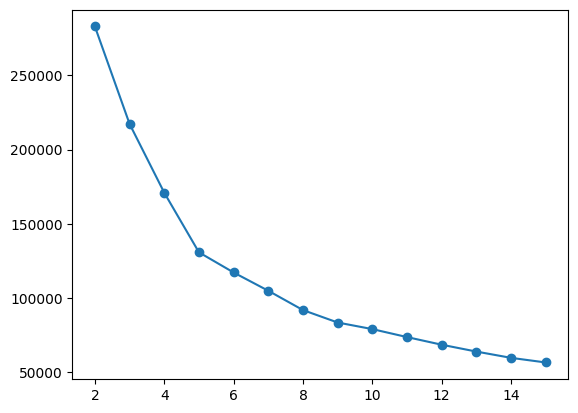

In [ ]:
#Appliquer le k-means
cluster_rangeS = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

inertieS = []

for c in cluster_rangeS:
  kmeans1 = KMeans(init = 'k-means++', n_clusters = c).fit(std_segmented_rfms_clust)
  inertieS.append(kmeans1.inertia_)

#Afficher l'inertie

plt.Figure()
plt.plot(cluster_rangeS,inertieS, marker ='o')
plt.show()

Avec le graphe montrant les inertie, avec la méthode du coude on partira sur 5 clusters

In [ ]:
#ON utilisera 5 clusters

kmeans1 = KMeans(n_clusters= 5).fit(std_segmented_rfms_clust)
labels1 = kmeans1.labels_
new_segmented_rfms_clust = pd.DataFrame(data = std_segmented_rfms_clust, columns =['recency', 'frequency', 'monetary_value','score_review'])
new_segmented_rfms_clust['labels_kmeans'] = labels1
new_segmented_rfms_clust

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,recency,frequency,monetary_value,score_review,labels_kmeans
0,-0.835036,-0.162368,-0.095850,0.473583,2
1,-0.815482,-0.162368,-0.596846,-0.115780,2
2,1.941708,-0.162368,-0.339033,-0.705143,1
3,0.533782,-0.162368,-0.525088,-0.115780,1
4,0.318682,-0.162368,0.144319,0.473583,1
...,...,...,...,...,...
96091,1.355072,-0.162368,8.313862,0.473583,4
96092,0.149209,-0.162368,-0.346195,-0.115780,1
96093,2.143772,-0.162368,-0.224430,0.473583,1
96094,-0.782891,-0.162368,-0.131707,0.473583,2


In [ ]:
clusterS0 = new_segmented_rfms_clust[['recency', 'frequency', 'monetary_value','score_review']][new_segmented_rfms_clust['labels_kmeans']==0]
clusterS1 = new_segmented_rfms_clust[['recency', 'frequency', 'monetary_value','score_review']][new_segmented_rfms_clust['labels_kmeans']==1]
clusterS2 = new_segmented_rfms_clust[['recency', 'frequency', 'monetary_value','score_review']][new_segmented_rfms_clust['labels_kmeans']==2]
clusterS3 = new_segmented_rfms_clust[['recency', 'frequency', 'monetary_value','score_review']][new_segmented_rfms_clust['labels_kmeans']==3]
clusterS4 = new_segmented_rfms_clust[['recency', 'frequency', 'monetary_value','score_review']][new_segmented_rfms_clust['labels_kmeans']==4]

In [ ]:
#Visualiser
#Radar plot
# labels_kmeans = 0
cS0 = clusterS0.describe()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=cS0.loc['min'],
      theta=cS0.columns,
      fill='toself',
      name='Minimun'
))
fig.add_trace(go.Scatterpolar(
      r=cS0.loc['50%'],
      theta=cS0.columns,
      fill='toself',
      name='Medium'
))
# fig.add_trace(go.Scatterpolar(
#       r=cS0.loc['max'],
#       theta=cS0.columns,
#       fill='toself',
#       name='Maximun'
# ))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 5]
    )),
  width = 600, height = 500,
  showlegend=True
)
fig.show()

In [ ]:
#Visualiser
#Radar plot
# labels_kmeans = 1
cS1 = clusterS1.describe()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=cS1.loc['min'],
      theta=cS1.columns,
      fill='toself',
      name='Minimun'
))
fig.add_trace(go.Scatterpolar(
      r=cS1.loc['50%'],
      theta=cS1.columns,
      fill='toself',
      name='Medium'
))
# fig.add_trace(go.Scatterpolar(
#       r=cS1.loc['max'],
#       theta=cS1.columns,
#       fill='toself',
#       name='Maximun'
# ))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 5]
    )),
  width = 600, height = 500,
  showlegend=True
)
fig.show()

In [ ]:
#Visualiser
#Radar plot
# labels_kmeans = 2
cS2 = clusterS2.describe()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=cS2.loc['min'],
      theta=cS2.columns,
      fill='toself',
      name='Minimun'
))
fig.add_trace(go.Scatterpolar(
      r=cS2.loc['50%'],
      theta=cS2.columns,
      fill='toself',
      name='Medium'
))
# fig.add_trace(go.Scatterpolar(
#       r=cS2.loc['max'],
#       theta=cS2.columns,
#       fill='toself',
#       name='Maximun'
# ))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 5]
    )),
  width = 600, height = 500,
  showlegend=True
)
fig.show()

In [ ]:
#Visualiser
#Radar plot
# labels_kmeans = 3
cS3 = clusterS3.describe()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=cS3.loc['min'],
      theta=cS3.columns,
      fill='toself',
      name='Minimun'
))
fig.add_trace(go.Scatterpolar(
      r=cS3.loc['50%'],
      theta=cS3.columns,
      fill='toself',
      name='Medium'
))
# fig.add_trace(go.Scatterpolar(
#       r=cS3.loc['max'],
#       theta=cS3.columns,
#       fill='toself',
#       name='Maximun'
# ))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 5]
    )),
  width = 600, height = 500,
  showlegend=True
)
fig.show()

In [ ]:
#Visualiser
#Radar plot
# labels_kmeans = 4
cS4 = clusterS4.describe()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=cS4.loc['min'],
      theta=cS4.columns,
      fill='toself',
      name='Minimun'
))
fig.add_trace(go.Scatterpolar(
      r=cS4.loc['50%'],
      theta=cS4.columns,
      fill='toself',
      name='Medium'
))
# fig.add_trace(go.Scatterpolar(
#       r=cS4.loc['max'],
#       theta=cS4.columns,
#       fill='toself',
#       name='Maximun'
# ))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-2, 5]
    )),
  width = 600, height = 500,
  showlegend=True
)
fig.show()

## DBSCAN

###Modélisation du DBSCAN avec RFM (avec les variables Recence - Fréquence - Montant )

In [ ]:
segmented_rfm

,recency,frequency,monetary_value,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90,76.26,48.44,48.44,2.63,Low Value Customers
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19,75.24,48.44,48.44,2.62,Low Value Customers
0000f46a3911fa3c0805444483337064,585,1,86.22,3.66,48.44,48.44,2.09,Low Value Customers
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,28.92,48.44,48.44,2.28,Low Value Customers
0004aac84e0df4da2b147fca70cf8255,336,1,196.89,33.97,48.44,48.44,2.31,Low Value Customers
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,495,1,2067.42,12.43,48.44,48.44,2.15,Low Value Customers
fffea47cd6d3cc0a88bd621562a9d061,310,1,84.58,41.73,48.44,48.44,2.37,Low Value Customers
ffff371b4d645b6ecea244b27531430a,616,1,112.46,1.57,48.44,48.44,2.07,Low Value Customers


In [ ]:
X_train = segmented_rfm[['recency', 'frequency', 'monetary_value']]
X_train

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19
0000f46a3911fa3c0805444483337064,585,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62
0004aac84e0df4da2b147fca70cf8255,336,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,495,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,310,1,84.58
ffff371b4d645b6ecea244b27531430a,616,1,112.46


In [ ]:
X_train = StandardScaler().fit_transform(X_train)
X_train

array([[-0.83503622, -0.16236828, -0.09585028],
       [-0.81548168, -0.16236828, -0.59684641],
       [ 1.9417083 , -0.16236828, -0.33903278],
       ...,
       [ 2.14377187, -0.16236828, -0.22442953],
       [-0.78289079, -0.16236828, -0.13170747],
       [ 1.59624478, -0.16236828, -0.40306035]])

In [ ]:
# Normalizing the data so that
# the data approximately follows a Gaussian distribution
# X_normalized_dbscan = normalize(X_train)

# # Converting the numpy array into a pandas DataFrame
# X_normalized_dbscan = pd.DataFrame(X_normalized_dbscan)

In [ ]:
#X_normalized_dbscan

In [ ]:
# Converting the numpy array into a pandas DataFrame
X_train = pd.DataFrame(X_train)

####Variation des l'hyperparamètres "eps =12,5"


eps = 12,5

In [ ]:
clustering = DBSCAN(eps=12.5, min_samples=100).fit(X_train[:30000])

In [ ]:
DBSCAN_dataset = X_train.sample(n=30000).copy()
labels = clustering.labels_
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_
DBSCAN_dataset.loc[:,'Cluster']
DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
0,29995
-1,5


In [ ]:
DBSCAN_dataset

,0,1,2,Cluster
38055,0.142691,-0.162368,-0.151143,0
79898,-0.241882,-0.162368,-0.289724,0
50235,-1.317382,-0.162368,-0.209580,0
4680,-1.506409,-0.162368,-0.016274,0
86509,-0.496091,-0.162368,-0.006884,0
...,...,...,...,...
51028,0.331718,-0.162368,-0.267318,0
35529,1.113899,-0.162368,-0.567104,0
54806,-1.063173,-0.162368,-0.129917,0
89479,-1.369527,-0.162368,0.408771,0


In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 5


#### eps = 10

In [ ]:
clustering = DBSCAN(eps=10, min_samples=100).fit(X_train[:30000])

In [ ]:
DBSCAN_dataset = X_train.sample(n=30000).copy()
labels = clustering.labels_
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_
DBSCAN_dataset.loc[:,'Cluster']
DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
0,29994
-1,6


In [ ]:
DBSCAN_dataset

,0,1,2,Cluster
75974,0.866209,-0.162368,-0.009723,0
40705,-1.336936,-0.162368,-0.462327,0
15745,-1.089245,-0.162368,-0.490934,0
42556,-1.356491,-0.162368,-0.258147,0
85471,-0.280991,-0.162368,-0.420792,0
...,...,...,...,...
4832,0.260018,-0.162368,-0.498971,0
43510,1.707054,-0.162368,-0.405812,0
55309,1.824381,-0.162368,-0.530155,0
51238,1.407218,-0.162368,-0.248407,0


In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 6


#### eps = 5

In [ ]:
clustering = DBSCAN(eps=5, min_samples=100).fit(X_train[:30000])

In [ ]:
DBSCAN_dataset = X_train.sample(n=30000).copy()
labels = clustering.labels_
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_
DBSCAN_dataset.loc[:,'Cluster']
DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
0,29983
-1,17


In [ ]:
DBSCAN_dataset

,0,1,2,Cluster
344,0.129654,-0.162368,-0.431711,0
49696,2.261099,-0.162368,0.903347,0
82314,-0.026782,-0.162368,-0.196172,0
67414,1.368108,-0.162368,-0.461891,0
28894,2.150290,-0.162368,0.429211,0
...,...,...,...,...
67504,-0.176700,-0.162368,-0.523429,0
66199,-0.372245,-0.162368,0.124883,0
57971,-0.619936,-0.162368,-0.559373,0
44135,0.468600,-0.162368,-0.431318,0


In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 17


####En faisant varier les hyperparamètres ont ne trouve que un cluster. Ce qui montre que la méthode DBSCAN n'est pas approprié à notre jeu de données car elle fonctionnent par densité. ALors que dans notre data set le nombre de bon clients est très faibles (soit 3% du dataset)

###Modélisation du DBSCAN avec RFMS (avec les variables Recence - Fréquence - Montant - Score review)

In [ ]:
segmented_rfms

,recency,frequency,monetary_value,score_review,R_rank_norm,F_rank_norm,M_rank_norm,S_rank_norm,RFMS_Score,Customer_segment
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90,5.0,76.26,48.44,48.44,69.54,2.74,Low Value Customers
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19,4.0,75.24,48.44,48.44,32.41,2.54,Low Value Customers
0000f46a3911fa3c0805444483337064,585,1,86.22,3.0,3.66,48.44,48.44,19.04,1.94,Low Value Customers
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,4.0,28.92,48.44,48.44,32.41,2.20,Low Value Customers
0004aac84e0df4da2b147fca70cf8255,336,1,196.89,5.0,33.97,48.44,48.44,69.54,2.42,Low Value Customers
...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,495,1,2067.42,5.0,12.43,48.44,48.44,69.54,2.26,Low Value Customers
fffea47cd6d3cc0a88bd621562a9d061,310,1,84.58,4.0,41.73,48.44,48.44,32.41,2.29,Low Value Customers
ffff371b4d645b6ecea244b27531430a,616,1,112.46,5.0,1.57,48.44,48.44,69.54,2.18,Low Value Customers


In [ ]:
X_train1 = segmented_rfms[['recency', 'frequency', 'monetary_value', 'score_review']]
X_train1

,recency,frequency,monetary_value,score_review
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19,4.0
0000f46a3911fa3c0805444483337064,585,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,336,1,196.89,5.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,495,1,2067.42,5.0
fffea47cd6d3cc0a88bd621562a9d061,310,1,84.58,4.0
ffff371b4d645b6ecea244b27531430a,616,1,112.46,5.0


In [ ]:
X_train1 = StandardScaler().fit_transform(X_train1)
X_train1

array([[-0.83503622, -0.16236828, -0.09585028,  0.47358321],
       [-0.81548168, -0.16236828, -0.59684641, -0.11578005],
       [ 1.9417083 , -0.16236828, -0.33903278, -0.70514331],
       ...,
       [ 2.14377187, -0.16236828, -0.22442953,  0.47358321],
       [-0.78289079, -0.16236828, -0.13170747,  0.47358321],
       [ 1.59624478, -0.16236828, -0.40306035,  0.47358321]])

In [ ]:
# Normalizing the data so that
# the data approximately follows a Gaussian distribution
# X_normalized_dbscan = normalize(X_train)

# # Converting the numpy array into a pandas DataFrame
# X_normalized_dbscan = pd.DataFrame(X_normalized_dbscan)

In [ ]:
#X_normalized_dbscan

In [ ]:
# Converting the numpy array into a pandas DataFrame
X_train1 = pd.DataFrame(X_train1)

####Variation des l'hyperparamètres "eps =12,5"


eps = 12,5

In [ ]:
clustering1 = DBSCAN(eps=12.5, min_samples=100).fit(X_train1[:30000])

In [ ]:
DBSCAN_dataset1 = X_train1.sample(n=30000).copy()
labels1 = clustering1.labels_
DBSCAN_dataset1.loc[:,'Cluster'] = clustering1.labels_
DBSCAN_dataset1.loc[:,'Cluster']
DBSCAN_dataset1.Cluster.value_counts().to_frame()

,Cluster
0,29995
-1,5


In [ ]:
DBSCAN_dataset1

,0,1,2,3,Cluster
23152,0.833618,-0.162368,-0.376812,0.473583,0
75244,-0.248400,-0.162368,-0.544829,0.473583,0
61786,-1.415154,-0.162368,-0.194468,-1.883870,0
76731,-0.091964,-0.162368,-0.413979,-1.883870,0
27601,-1.017545,-0.162368,-0.403978,0.473583,0
...,...,...,...,...,...
51817,2.965063,-0.162368,1.256066,-1.883870,0
24367,-0.496091,-0.162368,-0.149614,-1.883870,0
63568,0.260018,-0.162368,0.121564,-1.294507,0
64718,-1.252200,-0.162368,1.134781,-0.705143,0


In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters1_ = len(set(labels1)) - (1 if -1 in labels1 else 0)
n_noise1_ = list(labels1).count(-1)

print("Estimated number of clusters: %d" % n_clusters1_)
print("Estimated number of noise points: %d" % n_noise1_)

Estimated number of clusters: 1
Estimated number of noise points: 5


#### eps = 10

In [ ]:
clustering1 = DBSCAN(eps=10, min_samples=100).fit(X_train1[:30000])

In [ ]:
DBSCAN_dataset1 = X_train1.sample(n=30000).copy()
labels1 = clustering1.labels_
DBSCAN_dataset1.loc[:,'Cluster'] = clustering1.labels_
DBSCAN_dataset1.loc[:,'Cluster']
DBSCAN_dataset1.Cluster.value_counts().to_frame()

,Cluster
0,29992
-1,8


In [ ]:
DBSCAN_dataset1

,0,1,2,3,Cluster
9533,0.227427,-0.162368,-0.088513,-0.115780,0
8494,-0.443945,-0.162368,1.693035,0.473583,0
58084,-0.652527,-0.162368,-0.403191,0.473583,0
88926,1.328999,-0.162368,-0.471674,0.473583,0
47483,-0.222327,-0.162368,-0.445906,-0.115780,0
...,...,...,...,...,...
70120,-1.258718,-0.162368,0.543858,-0.115780,0
54088,-0.795927,-0.162368,-0.166866,0.473583,0
77920,-0.248400,-0.162368,-0.110263,0.473583,0
91729,-0.815482,-0.162368,0.116279,0.473583,0


In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters1_ = len(set(labels1)) - (1 if -1 in labels1 else 0)
n_noise1_ = list(labels1).count(-1)

print("Estimated number of clusters: %d" % n_clusters1_)
print("Estimated number of noise points: %d" % n_noise1_)

Estimated number of clusters: 1
Estimated number of noise points: 8


#### eps = 5

In [ ]:
clustering1 = DBSCAN(eps=5, min_samples=100).fit(X_train1[:30000])

In [ ]:
DBSCAN_dataset1 = X_train1.sample(n=30000).copy()
labels1 = clustering.labels_
DBSCAN_dataset1.loc[:,'Cluster'] = clustering1.labels_
DBSCAN_dataset1.loc[:,'Cluster']
DBSCAN_dataset1.Cluster.value_counts().to_frame()

,Cluster
0,29978
-1,22


In [ ]:
DBSCAN_dataset1

,0,1,2,3,Cluster
77485,-0.854591,-0.162368,-0.123890,0.473583,0
11255,-0.470018,-0.162368,-0.626545,-1.883870,0
14396,-0.137591,-0.162368,-0.242773,0.473583,0
30014,0.807545,-0.162368,-0.532164,0.473583,0
55072,-0.098482,-0.162368,-0.588941,0.473583,0
...,...,...,...,...,...
34527,-0.339655,-0.162368,1.158453,-0.115780,0
81176,-0.189736,-0.162368,-0.442106,0.473583,0
7126,-1.187018,-0.162368,0.254554,0.473583,0
58198,-0.463500,4.502189,-0.424898,3.420399,0


In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters1_ = len(set(labels1)) - (1 if -1 in labels1 else 0)
n_noise1_ = list(labels1).count(-1)

print("Estimated number of clusters: %d" % n_clusters1_)
print("Estimated number of noise points: %d" % n_noise1_)

Estimated number of clusters: 1
Estimated number of noise points: 17


In [ ]:
# outliers = DBSCAN_dataset[DBSCAN_dataset['Cluster']==-1]

# fig2, (axes) = plt.subplots(1,2,figsize=(12,5))

# sns.scatterplot('recency', 'frequency', data=DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1], hue='Cluster', ax=axes[0], palette='Set2', legend='full', s=200)

# sns.scatterplot('recency', 'frequency', data=DBSCAN_dataset[DBSCAN_dataset['Cluster']!=-1], hue='Cluster', palette='Set2', ax=axes[1], legend='full', s=200)

# axes[0].scatter(outliers['recency'], outliers['frequency'], s=10, label='outliers', c="k")

# axes[1].scatter(outliers['recency'], outliers['frequency'], s=10, label='outliers', c="k")
# axes[0].legend()
# axes[1].legend()

# plt.setp(axes[0].get_legend().get_texts(), fontsize='12')
# plt.setp(axes[1].get_legend().get_texts(), fontsize='12')

# plt.show()

####En faisant varier les hyperparamètres ont ne trouve que un cluster. Ce qui montre que la méthode DBSCAN n'est pas approprié à notre jeu de données car elle fonctionnent par densité. Alors que dans notre data set le nombre de bon clients est très faibles (soit 3% du dataset)

## CAH Classification Ascendante Hiérarchique : CAH

###CAH avec RFM

In [ ]:
Table = segmented_rfm[['recency', 'frequency', 'monetary_value']]

In [ ]:
X = Table.copy()
X.head()
# # Segmentation à l'aide d'une CAH
# y_pred = AgglomerativeClustering(n_clusters = 10).fit_predict(X_train_CAH )

# # Visualisation du résultat
# plt.figure(figsize = (5,5))
# plt.scatter(X_train_CAH['recency'],X_train_CAH['frequency'],c = y_pred);

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19
0000f46a3911fa3c0805444483337064,585,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62
0004aac84e0df4da2b147fca70cf8255,336,1,196.89


In [ ]:
#Preprocessing the data

# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled

array([[-0.83503622, -0.16236828, -0.09585028],
       [-0.81548168, -0.16236828, -0.59684641],
       [ 1.9417083 , -0.16236828, -0.33903278],
       ...,
       [ 2.14377187, -0.16236828, -0.22442953],
       [-0.78289079, -0.16236828, -0.13170747],
       [ 1.59624478, -0.16236828, -0.40306035]])

In [ ]:
# Normalizing the data so that
# the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)

# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

In [ ]:
X_normalized

,0,1,2
0,-0.975443,-0.189670,-0.111967
1,-0.796740,-0.158637,-0.583129
2,0.981771,-0.082097,-0.171423
3,0.696696,-0.211924,-0.685349
4,0.826284,-0.420992,0.374192
...,...,...,...
96091,0.160837,-0.019272,0.986793
96092,0.363516,-0.395576,-0.843431
96093,0.991755,-0.075115,-0.103826
96094,-0.966143,-0.200374,-0.162536


In [ ]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[0.61740589 0.25731978 0.05910004]
[0.66115751 0.2755544  0.06328809]


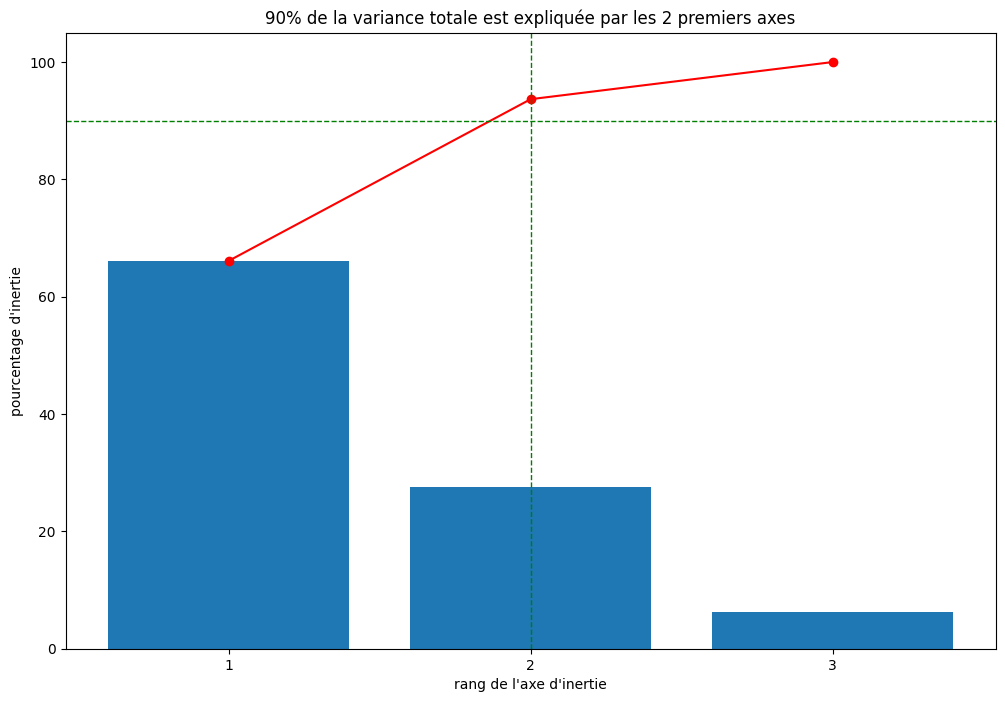

In [ ]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=90, linestyle="--",
            color="green",
            linewidth=1)

limit = 90
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--",
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [ ]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [ ]:
 X_train, X_test,  = train_test_split(
                     X_principal,  test_size=0.8, random_state=0)

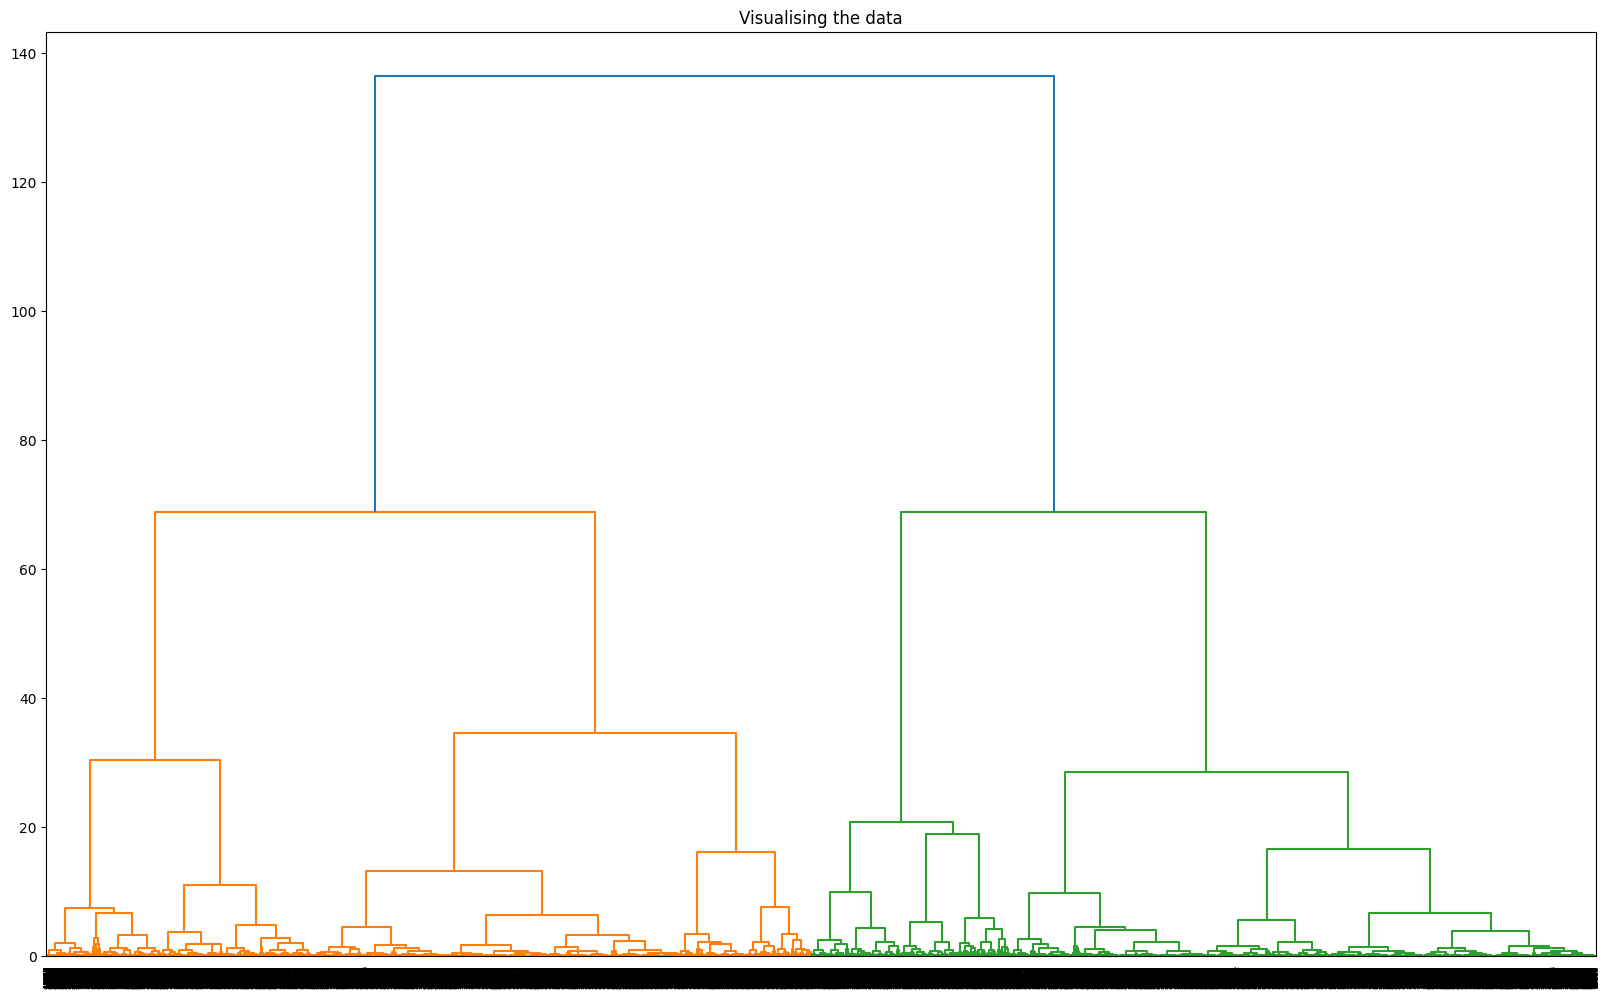

In [ ]:
# Dendograms are used to divide a given cluster into many different clusters.

# Step 5: Visualizing the working of the Dendograms

plt.figure(figsize =(20, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_train, method ='ward')))

In [ ]:
 y_train, y_test,  = train_test_split(
                     X_principal,  test_size=0.2, random_state=0)

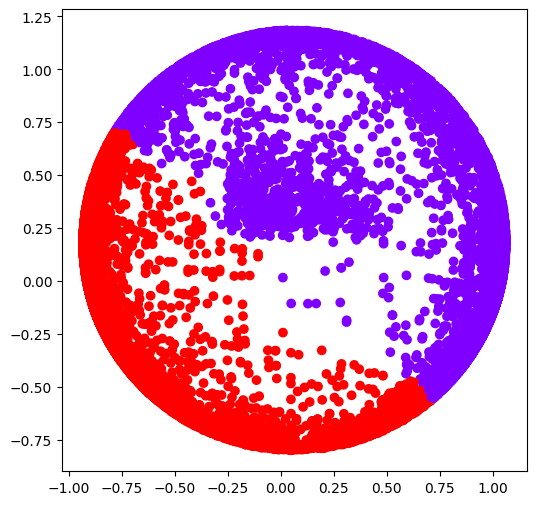

In [ ]:
# Step 6: Building and Visualizing the different clustering models for different values of k
# k = 2

ac2 = AgglomerativeClustering(n_clusters = 2)

# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac2.fit_predict(y_test), cmap ='rainbow')
plt.show()

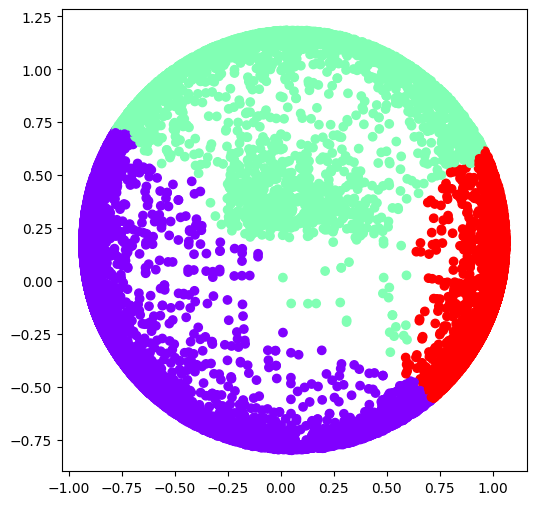

In [ ]:
# k = 3

ac3 = AgglomerativeClustering(n_clusters = 3)

plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac3.fit_predict(y_test), cmap ='rainbow')
plt.show()

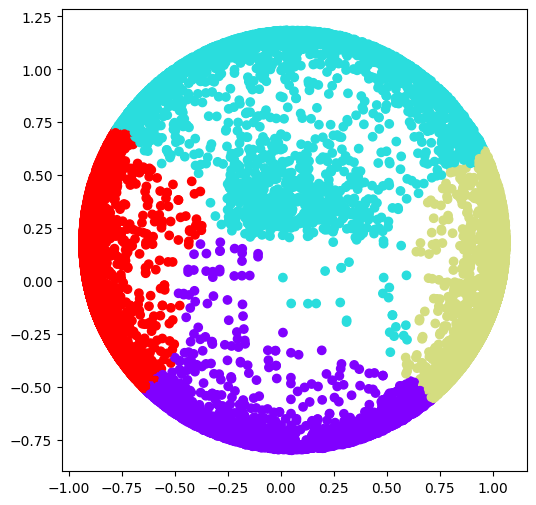

In [ ]:
# k = 4

ac4 = AgglomerativeClustering(n_clusters = 4)

plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac4.fit_predict(y_test), cmap ='rainbow')
plt.show()

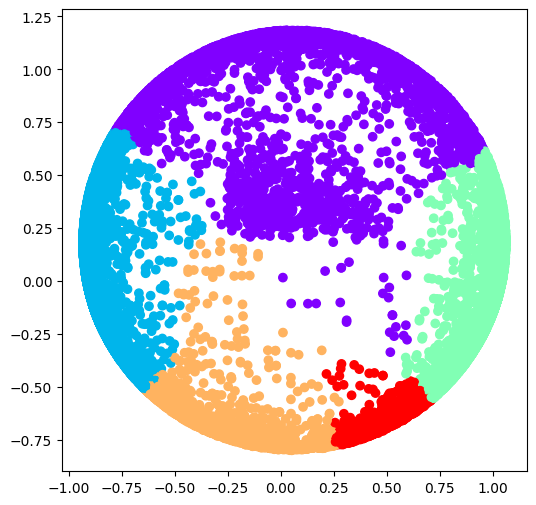

In [ ]:
# k = 5

ac5 = AgglomerativeClustering(n_clusters = 5)

plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac5.fit_predict(y_test), cmap ='rainbow')
plt.show()

In [ ]:
# Step 7: Evaluating the different models and Visualizing the results.

# Appending the silhouette scores of the different models to the list
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(y_test, ac2.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac3.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac4.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac5.fit_predict(y_test)))

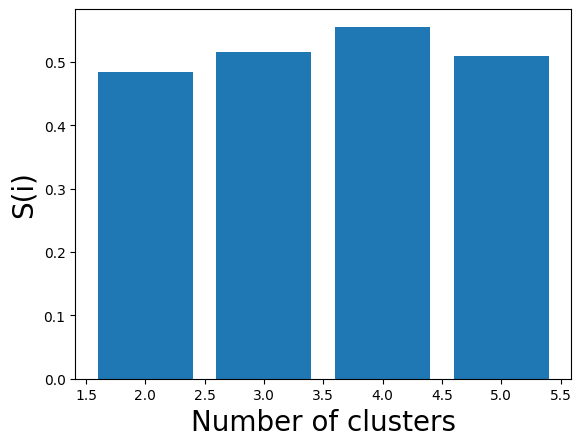

In [ ]:
# Plotting a bar graph to compare the results
k = [2, 3, 4, 5]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

Le nombre de cluster idéal est de 4

###CAH avec RFMS

In [ ]:
Table1 = segmented_rfms[['recency', 'frequency', 'monetary_value','score_review']]

In [ ]:
X1 = Table1.copy()
X1.head()
# # Segmentation à l'aide d'une CAH
# y_pred = AgglomerativeClustering(n_clusters = 10).fit_predict(X_train_CAH )

# # Visualisation du résultat
# plt.figure(figsize = (5,5))
# plt.scatter(X_train_CAH['recency'],X_train_CAH['frequency'],c = y_pred);

,recency,frequency,monetary_value,score_review
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,159,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,162,1,27.19,4.0
0000f46a3911fa3c0805444483337064,585,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,336,1,196.89,5.0


In [ ]:
#Preprocessing the data

# Scaling the data to bring all the attributes to a comparable level
scaler1 = StandardScaler()
X_scaled1 = scaler1.fit_transform(X1)

In [ ]:
X_scaled1

array([[-0.83503622, -0.16236828, -0.09585028,  0.47358321],
       [-0.81548168, -0.16236828, -0.59684641, -0.11578005],
       [ 1.9417083 , -0.16236828, -0.33903278, -0.70514331],
       ...,
       [ 2.14377187, -0.16236828, -0.22442953,  0.47358321],
       [-0.78289079, -0.16236828, -0.13170747,  0.47358321],
       [ 1.59624478, -0.16236828, -0.40306035,  0.47358321]])

In [ ]:

# Normalizing the data so that
# the data approximately follows a Gaussian distribution
X_normalized1 = normalize(X_scaled1)

# Converting the numpy array into a pandas DataFrame
X_normalized1 = pd.DataFrame(X_normalized1)

In [ ]:
X_normalized1

,0,1,2,3
0,-0.853538,-0.165966,-0.097974,0.484076
1,-0.791691,-0.157631,-0.579434,-0.112402
2,0.924753,-0.077329,-0.161467,-0.335830
3,0.688874,-0.209545,-0.677655,-0.149420
4,0.521777,-0.265845,0.236293,0.775397
...,...,...,...,...
96091,0.160583,-0.019242,0.985238,0.056122
96092,0.349863,-0.380719,-0.811755,-0.271480
96093,0.968777,-0.073375,-0.101420,0.214014
96094,-0.834134,-0.172996,-0.140328,0.504581


In [ ]:
# Explained variance
pca1 = PCA()
pca1.fit(X_normalized)

print(pca1.explained_variance_)
print(pca1.explained_variance_ratio_)

[0.61740589 0.25731978 0.05910004]
[0.66115751 0.2755544  0.06328809]


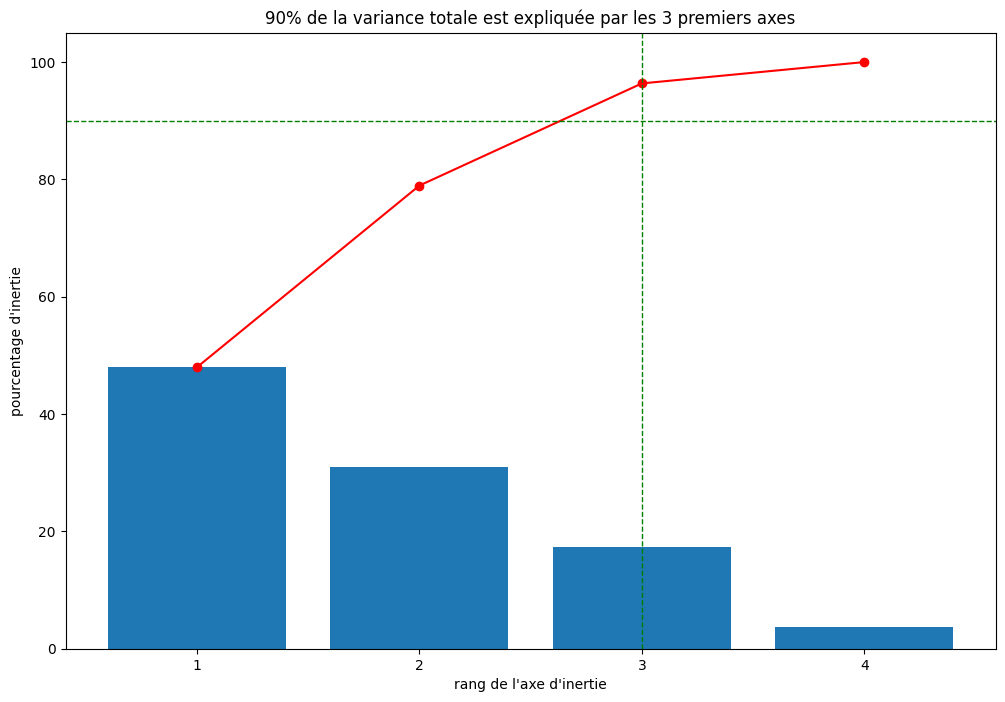

In [ ]:
# Explained variance
pca1 = PCA()
pca1.fit(X_normalized1)
varexpl1 = pca1.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl1))+1, varexpl1)

cumSumVar1 = varexpl1.cumsum()
plt.plot(np.arange(len(varexpl1))+1, cumSumVar1,c="red",marker='o')
plt.axhline(y=90, linestyle="--",
            color="green",
            linewidth=1)

limit = 90
valid_idx1 = np.where(cumSumVar1 >= limit)[0]
min_plans = valid_idx1[cumSumVar1[valid_idx1].argmin()]+1
plt.axvline(x=min_plans, linestyle="--",
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl1))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [ ]:
pca1 = PCA(n_components = 3)
X_principal1 = pca1.fit_transform(X_normalized1)
X_principal1 = pd.DataFrame(X_principal1)
X_principal1.columns = ['P1', 'P2', 'P3']

In [ ]:
 X_train1, X_test1,  = train_test_split(
                     X_principal1,  test_size=0.8, random_state=0)

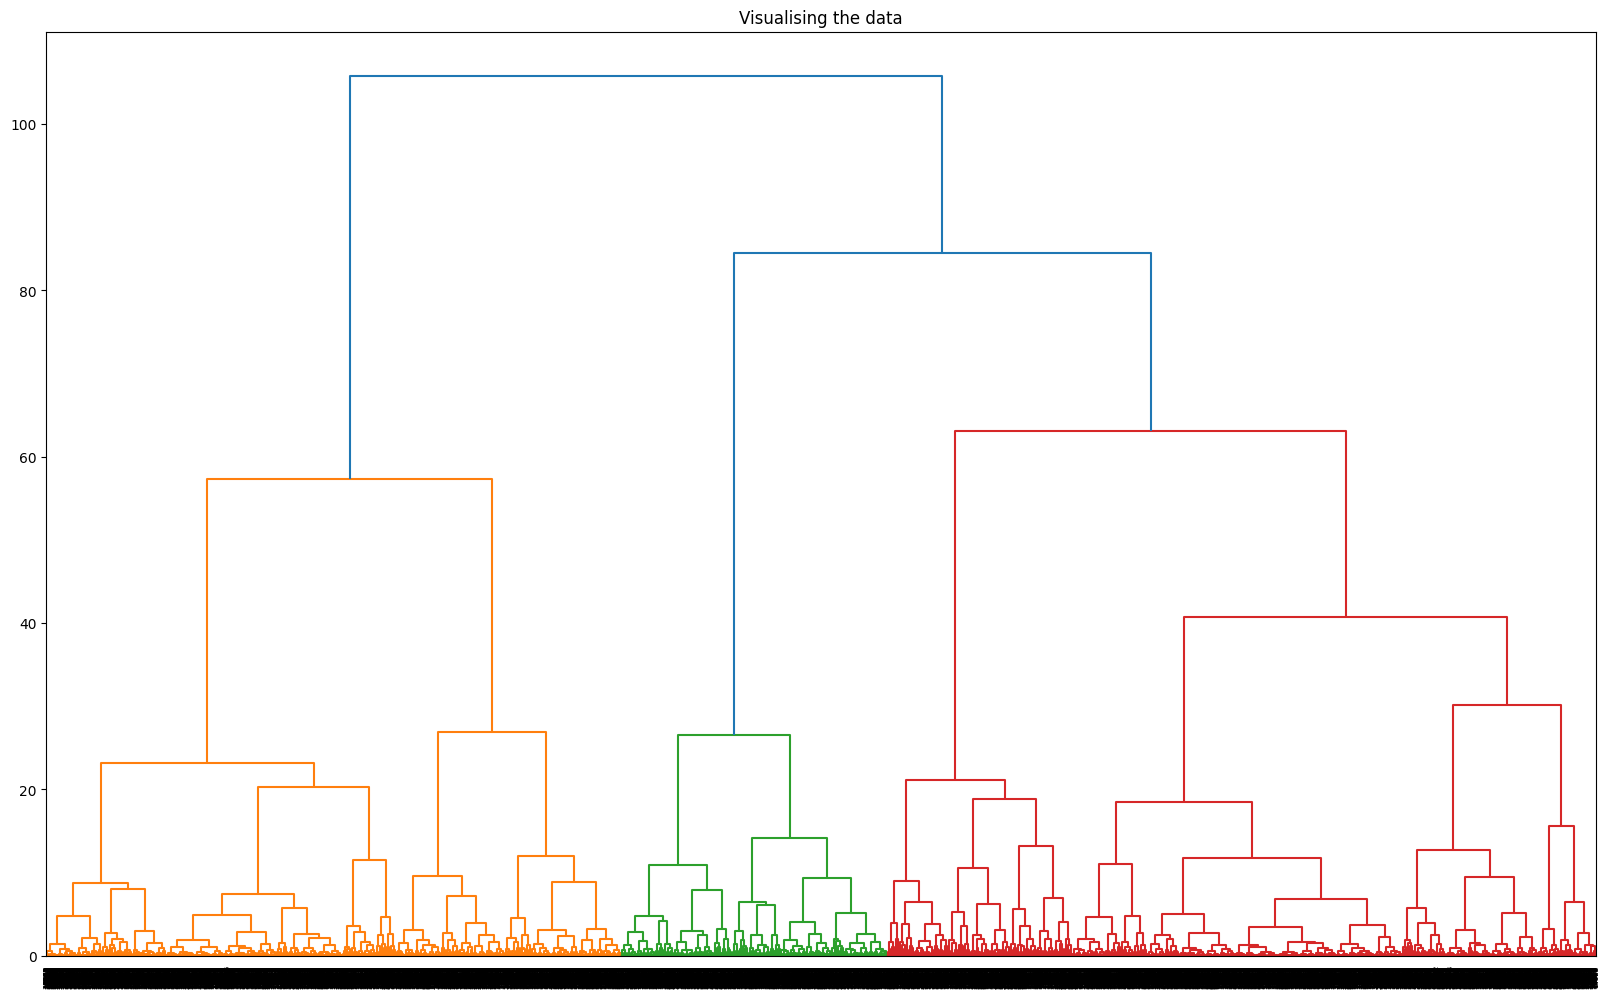

In [ ]:
# Dendograms are used to divide a given cluster into many different clusters.

# Step 5: Visualizing the working of the Dendograms

plt.figure(figsize =(20, 12))
plt.title('Visualising the data')
Dendrogram1 = shc.dendrogram((shc.linkage(X_train1, method ='ward')))

In [ ]:
 y_train1, y_test1,  = train_test_split(
                     X_principal1,  test_size=0.2, random_state=0)

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning:

invalid value encountered in sqrt



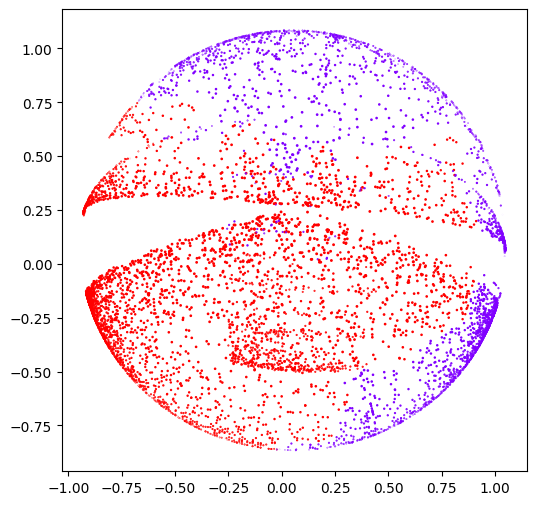

In [ ]:
# Step 6: Building and Visualizing the different clustering models for different values of k
# k = 2

acs2 = AgglomerativeClustering(n_clusters = 2)

# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(y_test1['P1'], y_test1['P2'], y_test1['P3'],
            c = acs2.fit_predict(y_test1), cmap ='rainbow')
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning:

invalid value encountered in sqrt



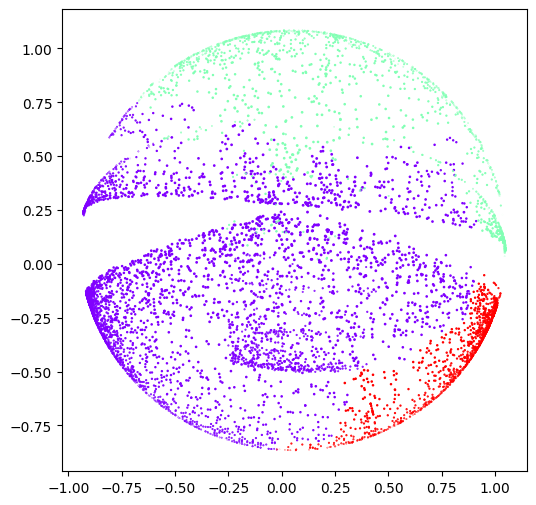

In [ ]:
# k = 3

acs3 = AgglomerativeClustering(n_clusters = 3)

plt.figure(figsize =(6, 6))
plt.scatter(y_test1['P1'], y_test1['P2'], y_test1['P3'],
            c = acs3.fit_predict(y_test1), cmap ='rainbow')
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning:

invalid value encountered in sqrt



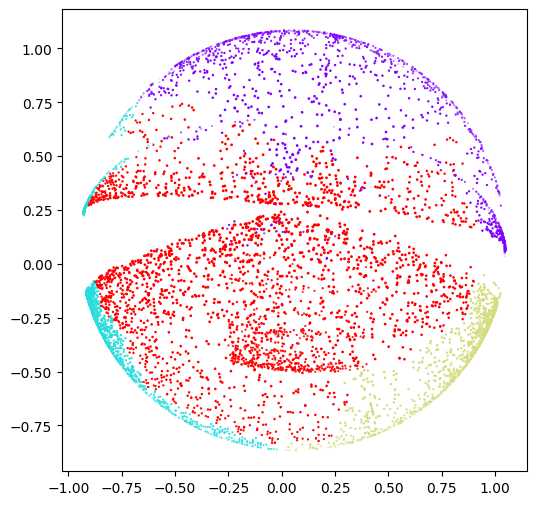

In [ ]:
# k = 4

acs4 = AgglomerativeClustering(n_clusters = 4)

plt.figure(figsize =(6, 6))
plt.scatter(y_test1['P1'], y_test1['P2'], y_test1['P3'],
            c = acs4.fit_predict(y_test1), cmap ='rainbow')
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning:

invalid value encountered in sqrt



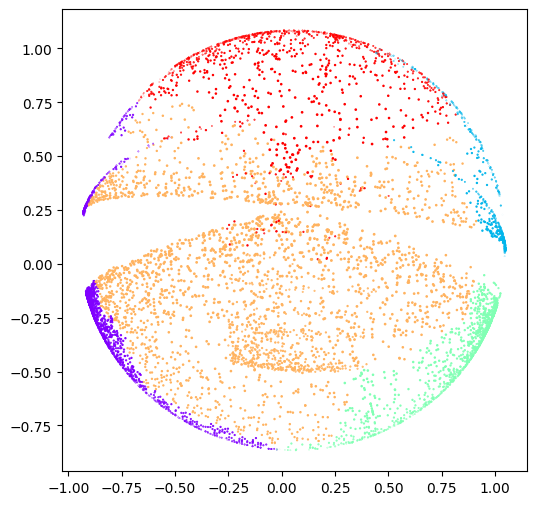

In [ ]:
# k = 5

acs5 = AgglomerativeClustering(n_clusters = 5)

plt.figure(figsize =(6, 6))
plt.scatter(y_test1['P1'], y_test1['P2'], y_test1['P3'],
            c = acs5.fit_predict(y_test1), cmap ='rainbow')
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning:

invalid value encountered in sqrt



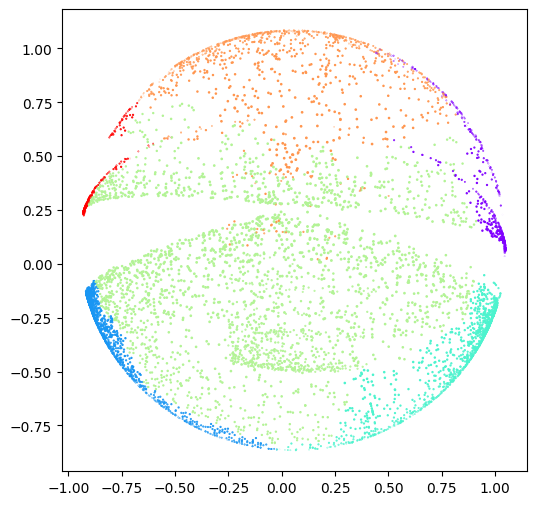

In [ ]:
# k = 6

acs6 = AgglomerativeClustering(n_clusters = 6)

plt.figure(figsize =(6, 6))
plt.scatter(y_test1['P1'], y_test1['P2'], y_test1['P3'],
            c = acs6.fit_predict(y_test1), cmap ='rainbow')
plt.show()

In [ ]:
# Step 7: Evaluating the different models and Visualizing the results.

# Appending the silhouette scores of the different models to the list
silhouette_scores1 = []
silhouette_scores1.append(
        silhouette_score(y_test1, acs2.fit_predict(y_test1)))
silhouette_scores1.append(
        silhouette_score(y_test1, acs3.fit_predict(y_test1)))
silhouette_scores1.append(
        silhouette_score(y_test1, acs4.fit_predict(y_test1)))
silhouette_scores1.append(
        silhouette_score(y_test1, acs5.fit_predict(y_test1)))
silhouette_scores1.append(
        silhouette_score(y_test1, acs6.fit_predict(y_test1)))

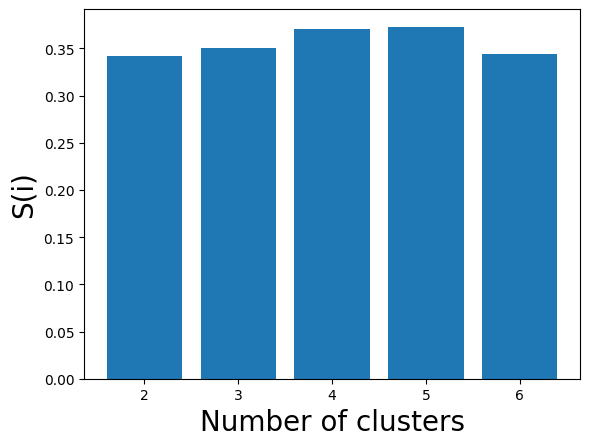

In [ ]:
# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6]
plt.bar(k, silhouette_scores1)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

Le nombre de cluster idéal est de 4

# Conclusion

De ces modélisations ont gardera donc la methode RFM comme modèle de classification pour notre étude.
Car elle permets de découper nos clients en des segments facile à comprendre